In [4]:
# Basic NGSolve things
from netgen.geom2d import unit_square
from ngsolve import *

# ngsxfem and the mlset convenience layer 
from xfem import *
from xfem.mlset import *

import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
matplotlib.rcParams.update({'font.size': 18})

# reference data from MFD
ref1 = np.loadtxt('data/REF_0p50p9LR.csv',comments='#',delimiter=',',skiprows=1)
ref2 = np.loadtxt('data/REF_0p50p9.csv',comments='#',delimiter=',',skiprows=1)

# THE HDG SOLVER

In [15]:
def HDG(order=0, nref = 0, s = 3, case = 1):
    h0 = 0.1
    eps = 1e-4
    K0, K1, K2 = 1, 1e4, 1e-4

    if case == 1:
        flag ="top|bottom"
    else:
        flag = "left|right"
    mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))

    nfs = 10
    # fracture locations: first two fractures are blocking, rest are conductive
    fracs = np.array([[0.1500,0.9167, 0.4000,0.5000], #B 
                      [0.6500,0.8333, 0.8500,0.1667], #B
                      [0.0500,0.4160, 0.2200,0.0624],         
                      [0.0500,0.2750, 0.2500,0.1350],         
                      [0.1500,0.6300, 0.4500,0.0900],         
                      [0.7000,0.2350, 0.8500,0.1675],         
                      [0.6000,0.3800, 0.8500,0.2675],         
                      [0.3500,0.9714, 0.8000,0.7143],         
                      [0.7500,0.9574, 0.9500,0.8155],         
                     [0.1500,0.8363, 0.4000,0.9727],         
                     ])
    
    def getMTL(F1):
        lset_p1 =  tuple(GridFunction(H1(mesh, order=1)) for i in range(2))
        x0, y0, x1, y1 = F1
        len1 = sqrt((x1-x0)**2+(y1-y0)**2)
        xmid, ymid = 0.5*(x0+x1), 0.5*(y0+y1)
        r1 = sqrt((x-xmid)**2+(y-ymid)**2)-0.5*len1
        l1 = (x-x0)*(y1-y0)-(y-y0)*(x1-x0)    
        InterpolateToP1(l1, lset_p1[0]) # line segment
        InterpolateToP1(r1, lset_p1[1]) # circ

        mlci = MultiLevelsetCutInfo(mesh, lset_p1)
        frac = DomainTypeArray((IF, NEG))
        lset_if = {"levelset": lset_p1, "domain_type": frac, "subdivlvl" : 0}
        lset_elem = mlci.GetElementsWithContribution(frac)

        ns = np.array([y1-y0, x0-x1])
        ns = ns/np.linalg.norm(ns)
        return lset_if, lset_elem, CF((ns[0], ns[1]))

    def getFracs(refine=False, onlyonce=False):
        lset_ifs, lset_elems, ns = [], [], []
        # get multi-lvl sets
        for i, F in enumerate(fracs):
            lset_if, lset_elem, n0 = getMTL(F)
            if i ==0:
                lset_Blocking = lset_elem
            elif i ==1:
                lset_Blocking |= lset_elem
            elif i==2: # get conductive fractured cells
                lset_elem &= ~lset_Blocking # removing blocking cells
                lset_Fracs = lset_elem
            else:
                lset_elem &= ~lset_Blocking # removing blocking cells
                lset_Fracs |= lset_elem
                
            lset_ifs.append(lset_if)
            lset_elems.append(lset_elem)
            ns.append(n0)
                                
        if refine ==True:
            for el in mesh.Elements(VOL):
                if lset_Fracs[el.nr] == True or lset_Blocking[el.nr]==True:
                    mesh.SetRefinementFlag(el, True)
                else:
                    mesh.SetRefinementFlag(el, False)
            mesh.Refine(onlyonce=onlyonce)
        return lset_ifs, lset_elems, ns, lset_Fracs, lset_Blocking

    for i in range(nref):
        getFracs(refine=True)
    lset_ifs, lset_elems, ns, lset_Fracs, lset_Blocking = getFracs(refine=False)
    
    # hybrid-mixed solver: GOOD
    V = VectorL2(mesh, order=order)
    W = L2(mesh, order=order, all_dofs_together=False)
    M = FacetFESpace(mesh, order=order, dirichlet=flag)

    fes = V*V*W*M
    (u, ut, p, phat), (v, vt, q, qhat) = fes.TnT()

    a = BilinearForm(fes, condense=True)
    h = specialcf.mesh_size
    n = specialcf.normal(2)

    a += 1/K0*(u-ut)*vt*dx
    a += (1/K0*(ut*v)+grad(p)*v-u*grad(q))*dx
    # boundary contribution
    a += (u*n*(q-qhat)-(p-phat)*v*n)*dx(element_boundary=True)
    # stabilization: Use same stabilization on blocking & regular cells
    a += K0*(p-phat)*(q-qhat)*dx(element_boundary=True, 
                                definedonelements=~lset_Fracs)
    # use strong stabilization on conductive cells
    a += K0*h**(-s)*(p-phat)*(q-qhat)*dx(element_boundary=True, 
                                definedonelements=lset_Fracs)
    for i in range(2): # blocking
        a += SymbolicBFI(levelset_domain = lset_ifs[i], 
                     form = eps/K2 * u*ns[i] * vt*ns[i],
                    definedonelements=lset_elems[i])
    for i in range(2, 10): # conductive
        a += SymbolicBFI(levelset_domain = lset_ifs[i], 
                         form = - eps*K1/K0**2 * (ut-ut*ns[i]*ns[i]) * (vt-vt*ns[i]*ns[i]),
                        definedonelements=lset_elems[i])

    f = LinearForm(fes)

    gfu = GridFunction(fes)

    with TaskManager():
        a.Assemble()
        f.Assemble()

        if case==1:
            # top dirichlet data
            gfu.components[3].Set(1+3*y, definedon=mesh.Boundaries(flag))
        else:
            # top dirichlet data
            gfu.components[3].Set(4-3*x, definedon=mesh.Boundaries(flag))

        # STATIC CONDENSATION SOLVER
        f.vec.data -= a.mat*gfu.vec
        f.vec.data += a.harmonic_extension_trans * f.vec
        gfu.vec.data += a.mat.Inverse(fes.FreeDofs(True), inverse="sparsecholesky")*f.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec 
        gfu.vec.data += a.inner_solve * f.vec

        # Local postprocessing
        V2 = L2(mesh, order=order+1, all_dofs_together=False)
        ph = GridFunction(V2)

        a2 = BilinearForm(V2)
        f2 = LinearForm(V2)

        p2, q2 = V2.TnT()
        a2 += grad(p2)*grad(q2)*dx
        a2.Assemble()
        f2 += -gfu.components[1]/K0*grad(q2)*dx
        f2.Assemble()

        V2.FreeDofs()[:mesh.ne]=False
        ph.vec[:mesh.ne].data=gfu.components[2].vec[:mesh.ne]
        ph.vec.data += a2.mat.Inverse(V2.FreeDofs(), inverse="sparsecholesky")*f2.vec
        
        if case ==1:
            xx = np.linspace(0, 1, 101)
            pre = np.array([ph(mesh(xx0,0.9+(xx0-1)*0.4)) for xx0 in xx])

            plt.figure(figsize=(10,8), dpi=400)

            print("Total: ", sum(fes.FreeDofs()), " Global: ", sum(fes.FreeDofs(True)), 
                 "V: ", sum(V.FreeDofs()), "W: ", sum(W.FreeDofs()), 
                  "M: ", sum(M.FreeDofs()), "ne: ", mesh.ne)
            plt.plot(ref2.T[3]*(1.16)**0.5, ref2.T[0], "k", linewidth=2)
            plt.plot(xx*(1.16)**0.5, pre, 'C1', linewidth=2)
            plt.legend(["reference", "HM-DFM"])
            plt.axis([0,1.1, 1.5,4])
            plt.xlabel("arc length", fontweight='bold')
            plt.ylabel("pressure", fontweight='bold')
            plt.savefig("data/complexA.pdf", dpi=400)
        else:
            xx = np.linspace(0, 1, 101)
            pre = np.array([ph(mesh(xx0,0.9+(xx0-1)*0.4)) for xx0 in xx])


            plt.figure(figsize=(10,8), dpi=400)

            plt.plot(ref1.T[3]*(1.16)**0.5, ref1.T[0], "k", linewidth=2)
            plt.plot(xx*(1.16)**0.5, pre, 'C1', linewidth=2)
            plt.legend(["reference", "HM-DFM"])
            plt.axis([0,1.1, 1.,4])
            plt.xlabel("arc length", fontweight='bold')
            plt.ylabel("pressure", fontweight='bold')
            plt.savefig("data/complexB.pdf", dpi=400)    
        return mesh, ph, gfu.components[0]

Total:  1495  Global:  345 V:  460 W:  230 M:  345 ne:  230
Total:  4140  Global:  690 V:  1380 W:  690 M:  690 ne:  230
Total:  7935  Global:  1035 V:  2760 W:  1380 M:  1035 ne:  230
Total:  25075  Global:  5785 V:  7716 W:  3858 M:  5785 ne:  3858
Total:  69440  Global:  11570 V:  23148 W:  11574 M:  11570 ne:  3858
Total:  133095  Global:  17355 V:  46296 W:  23148 M:  17355 ne:  3858


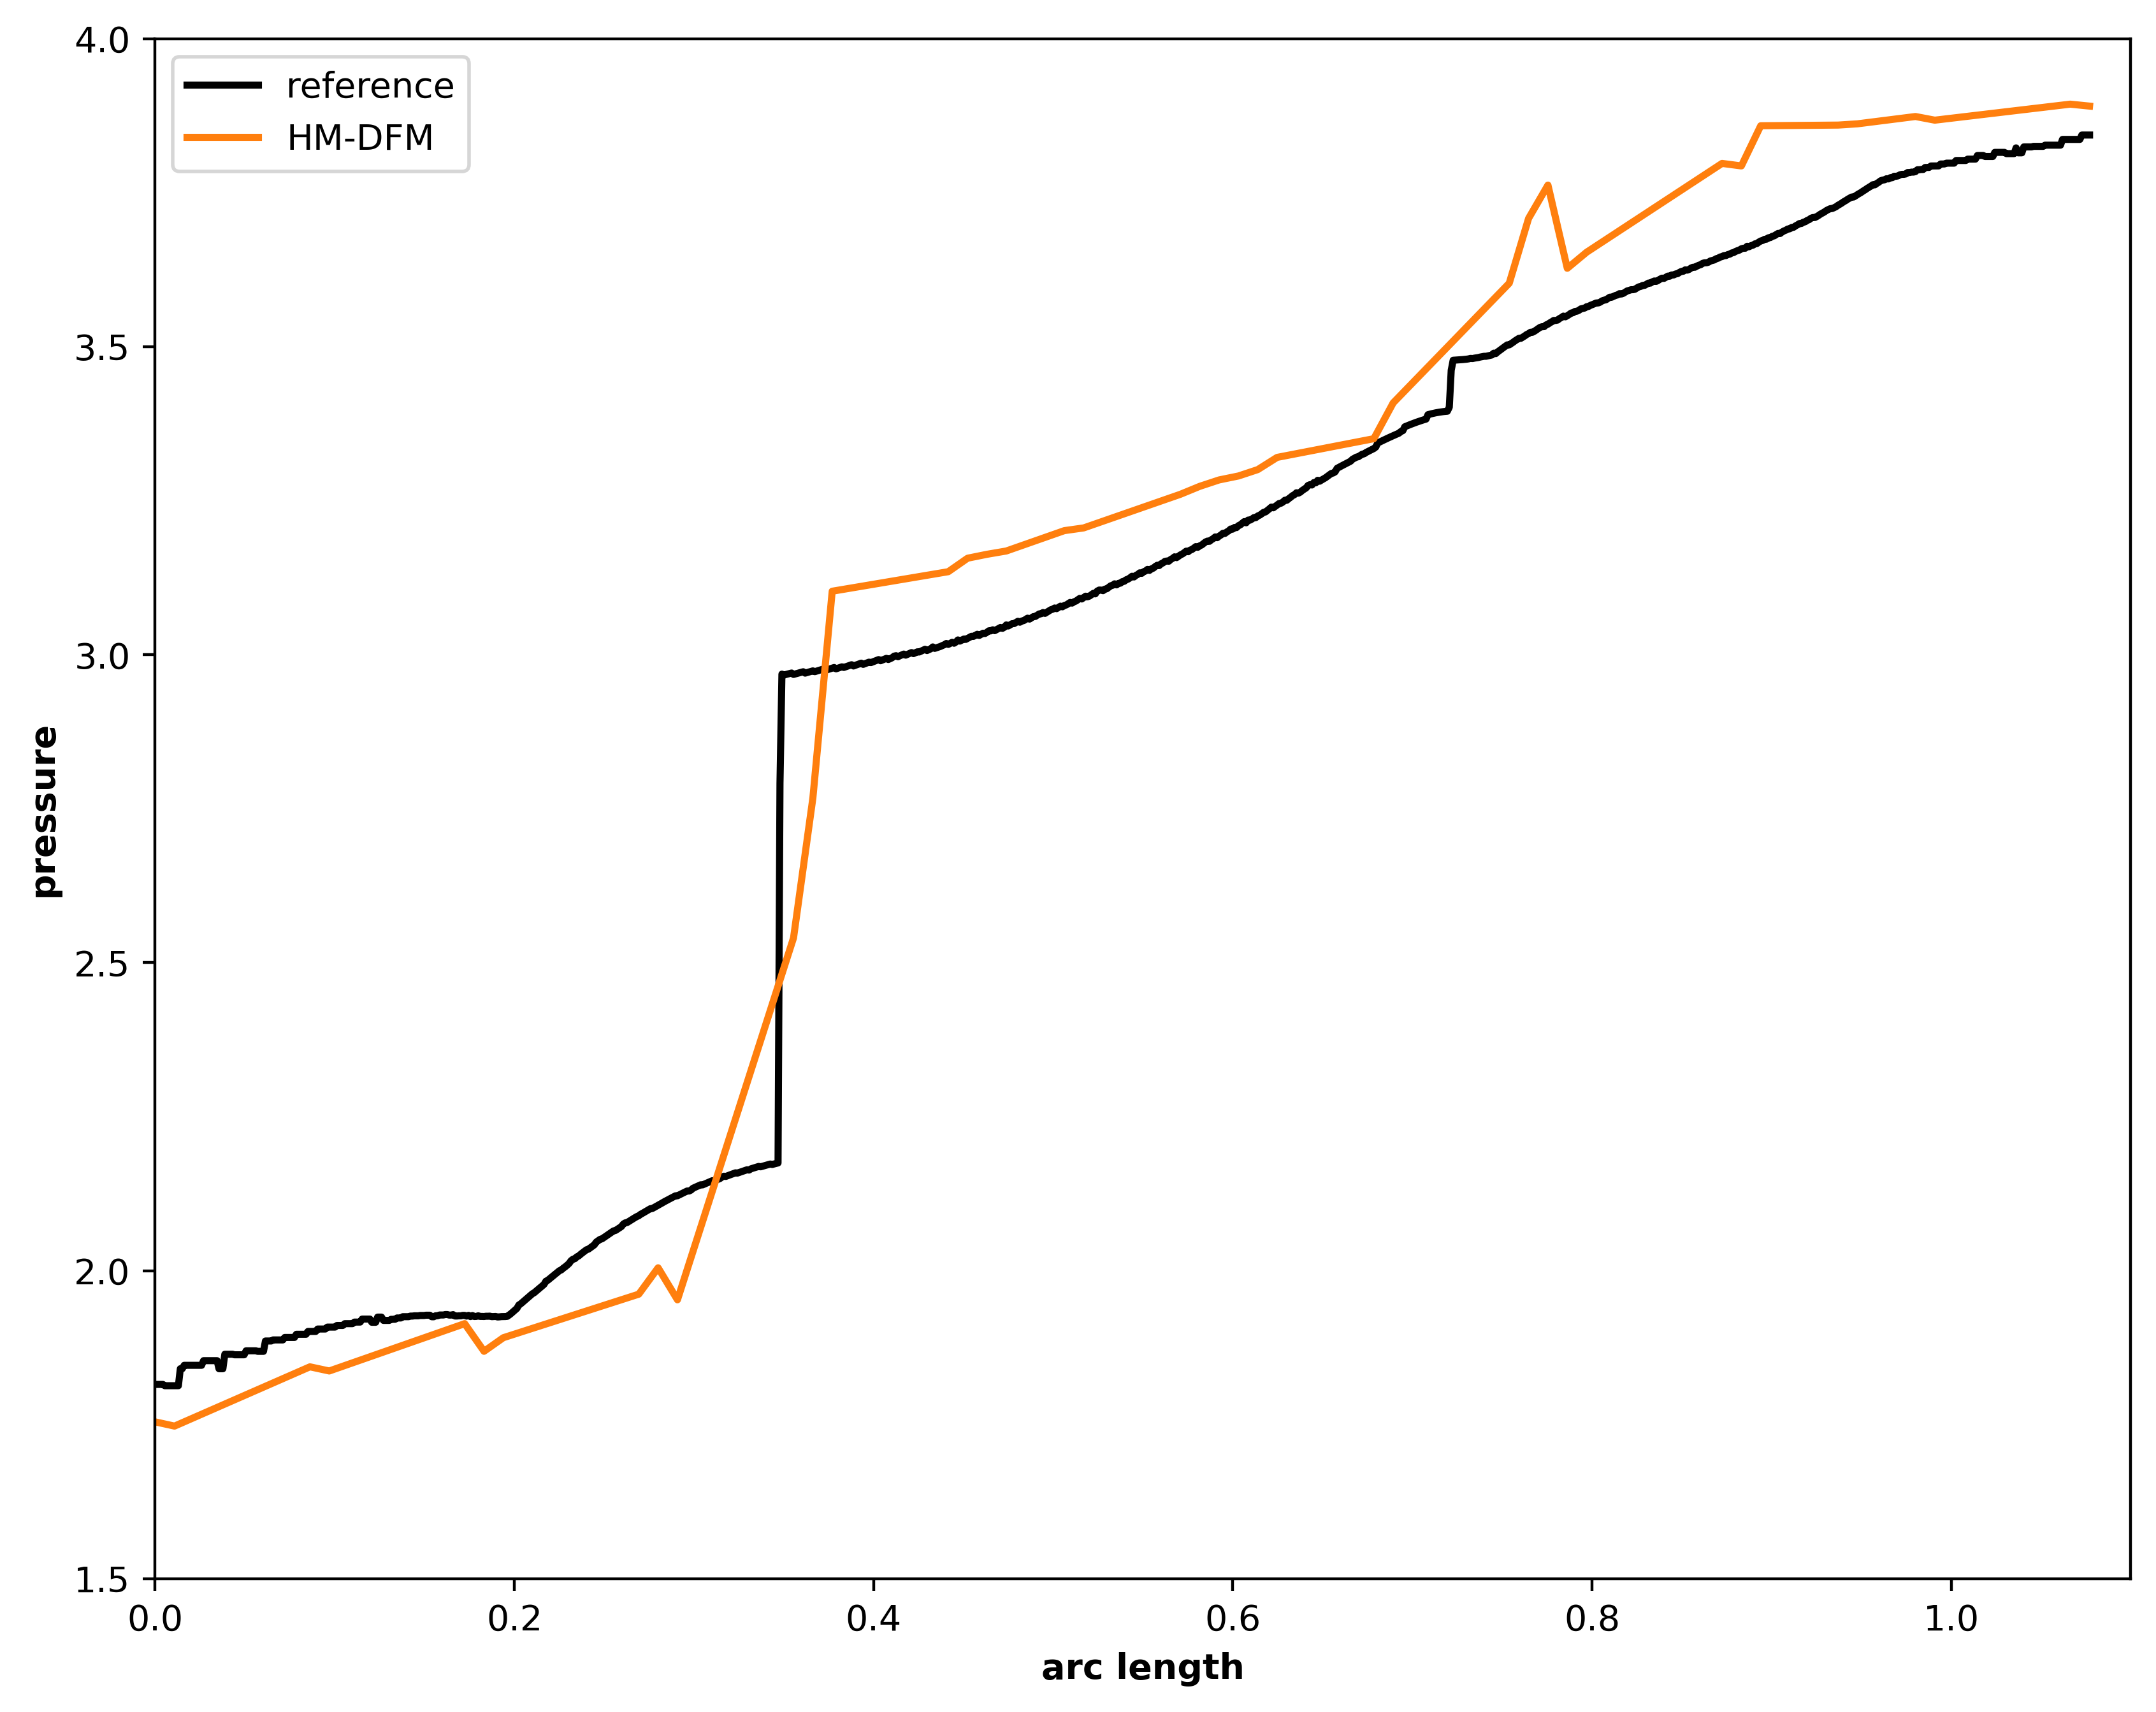

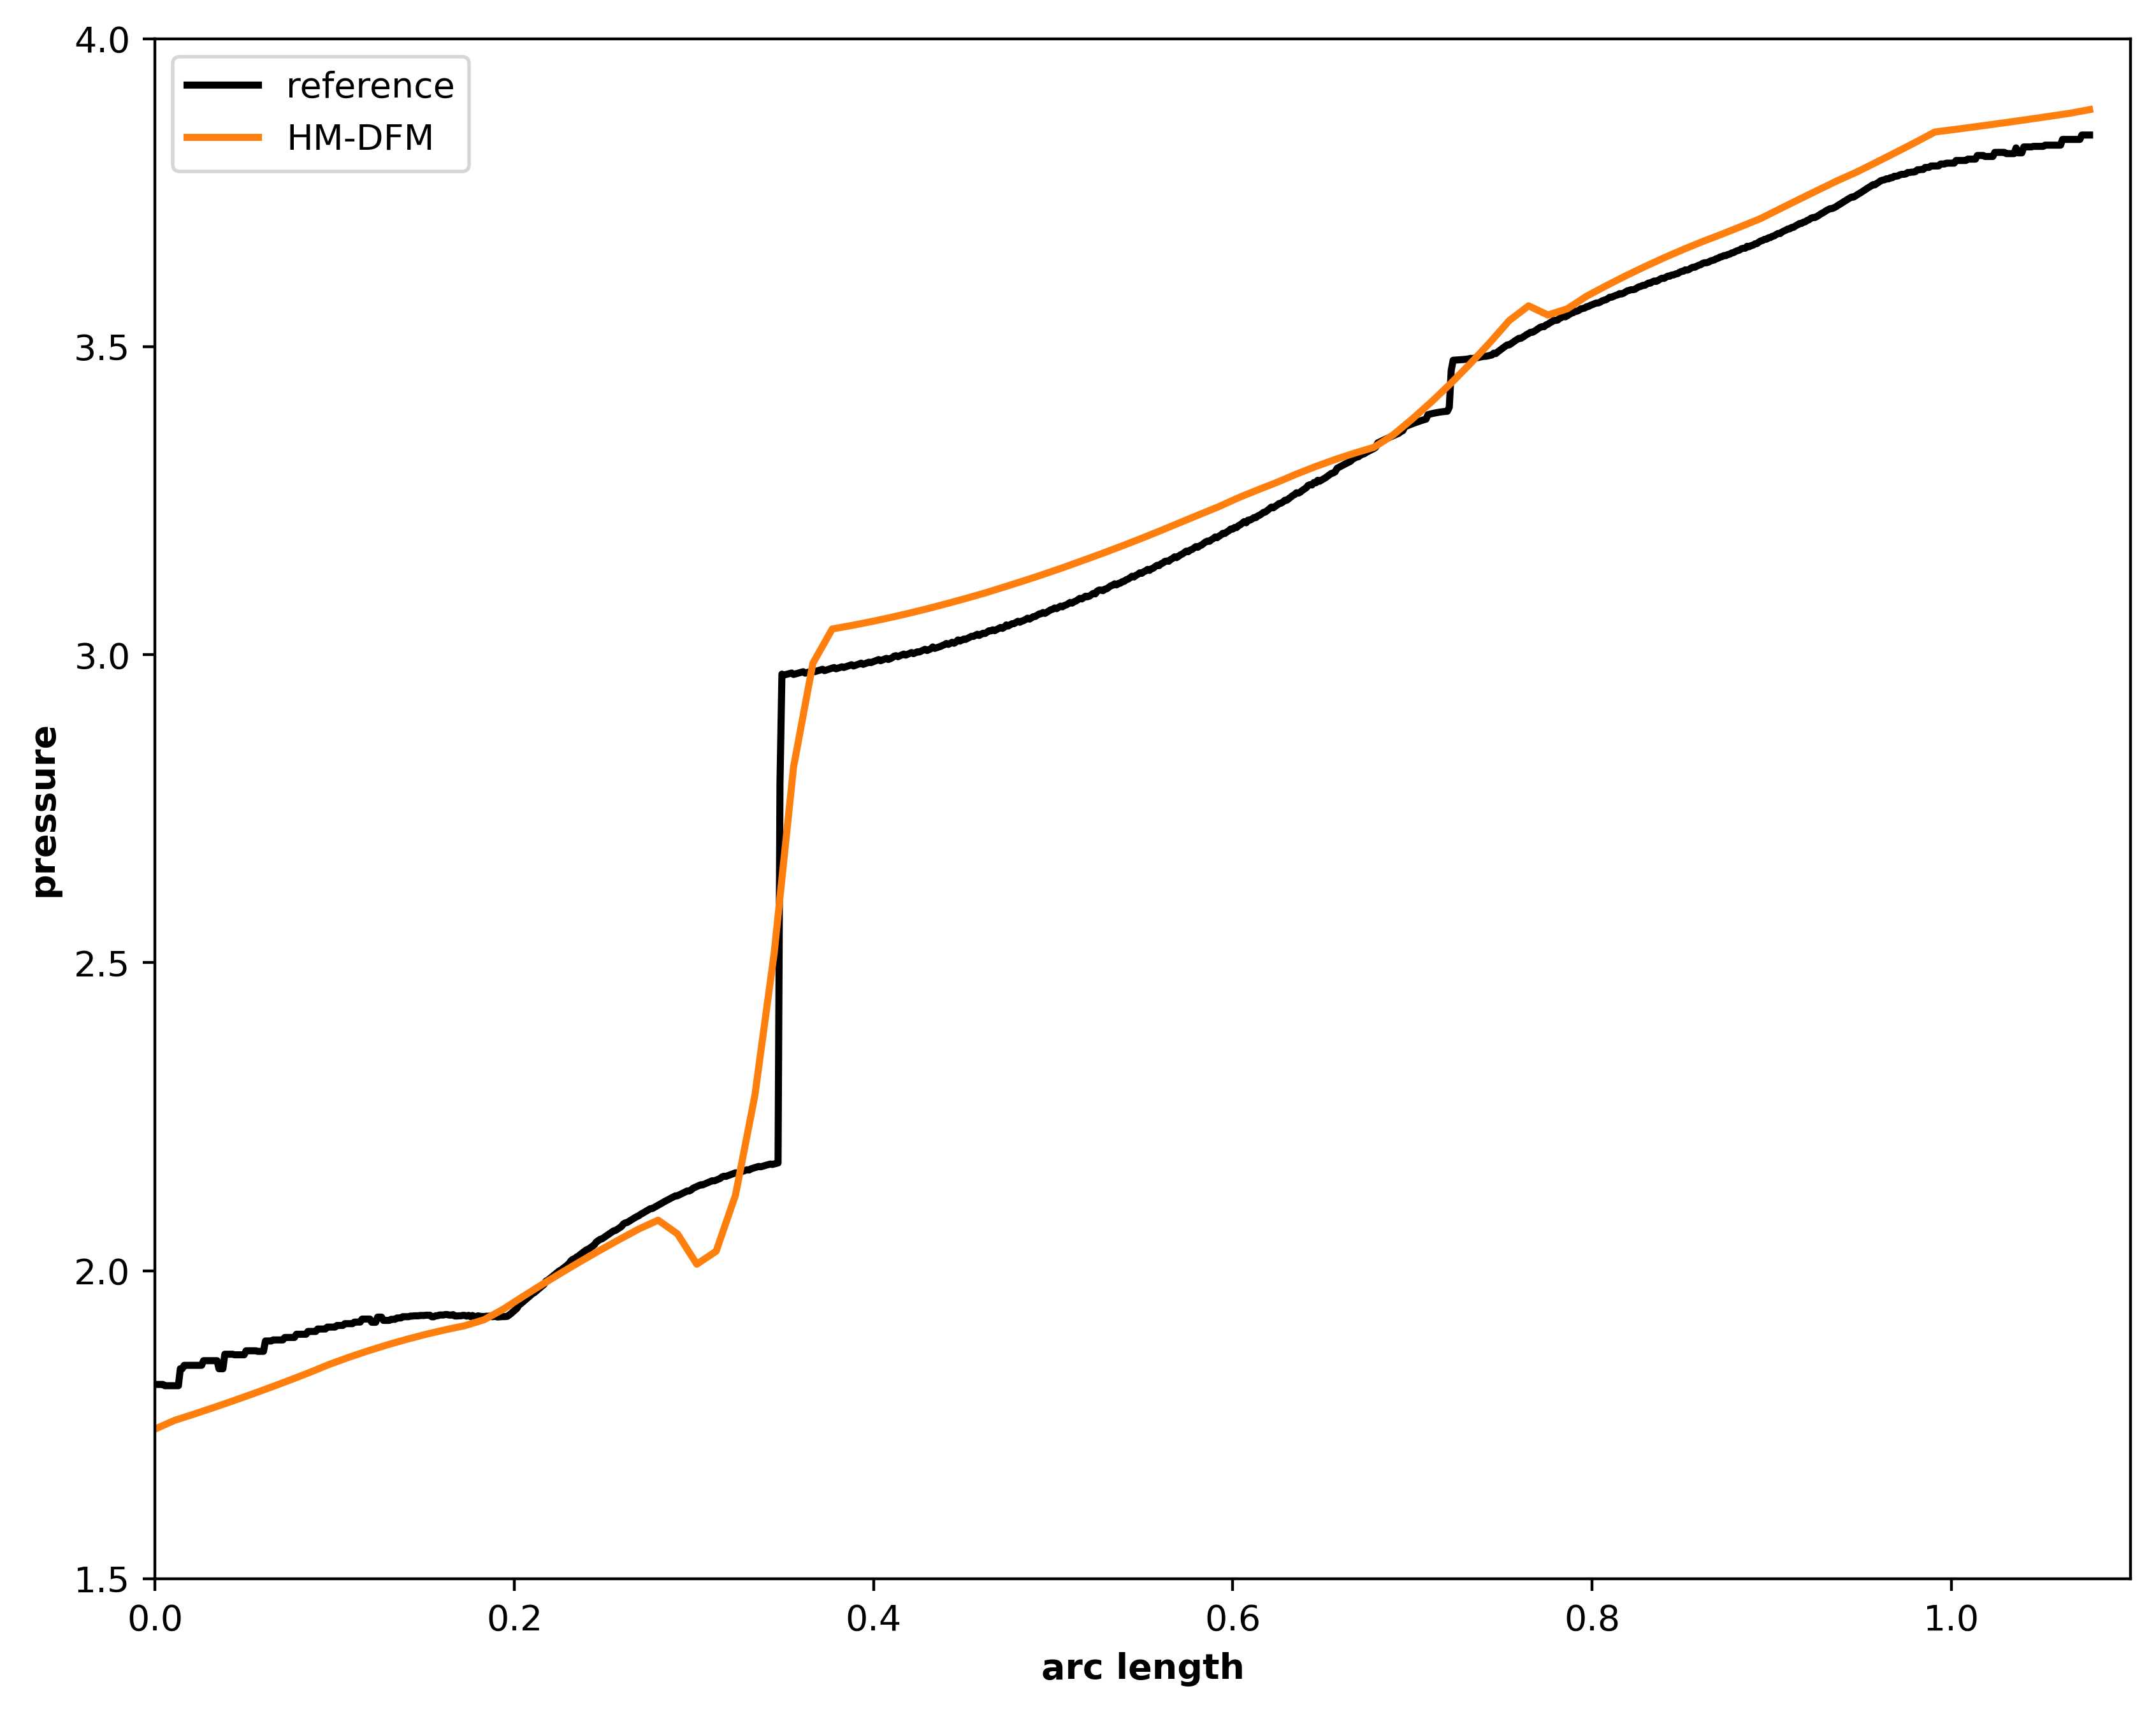

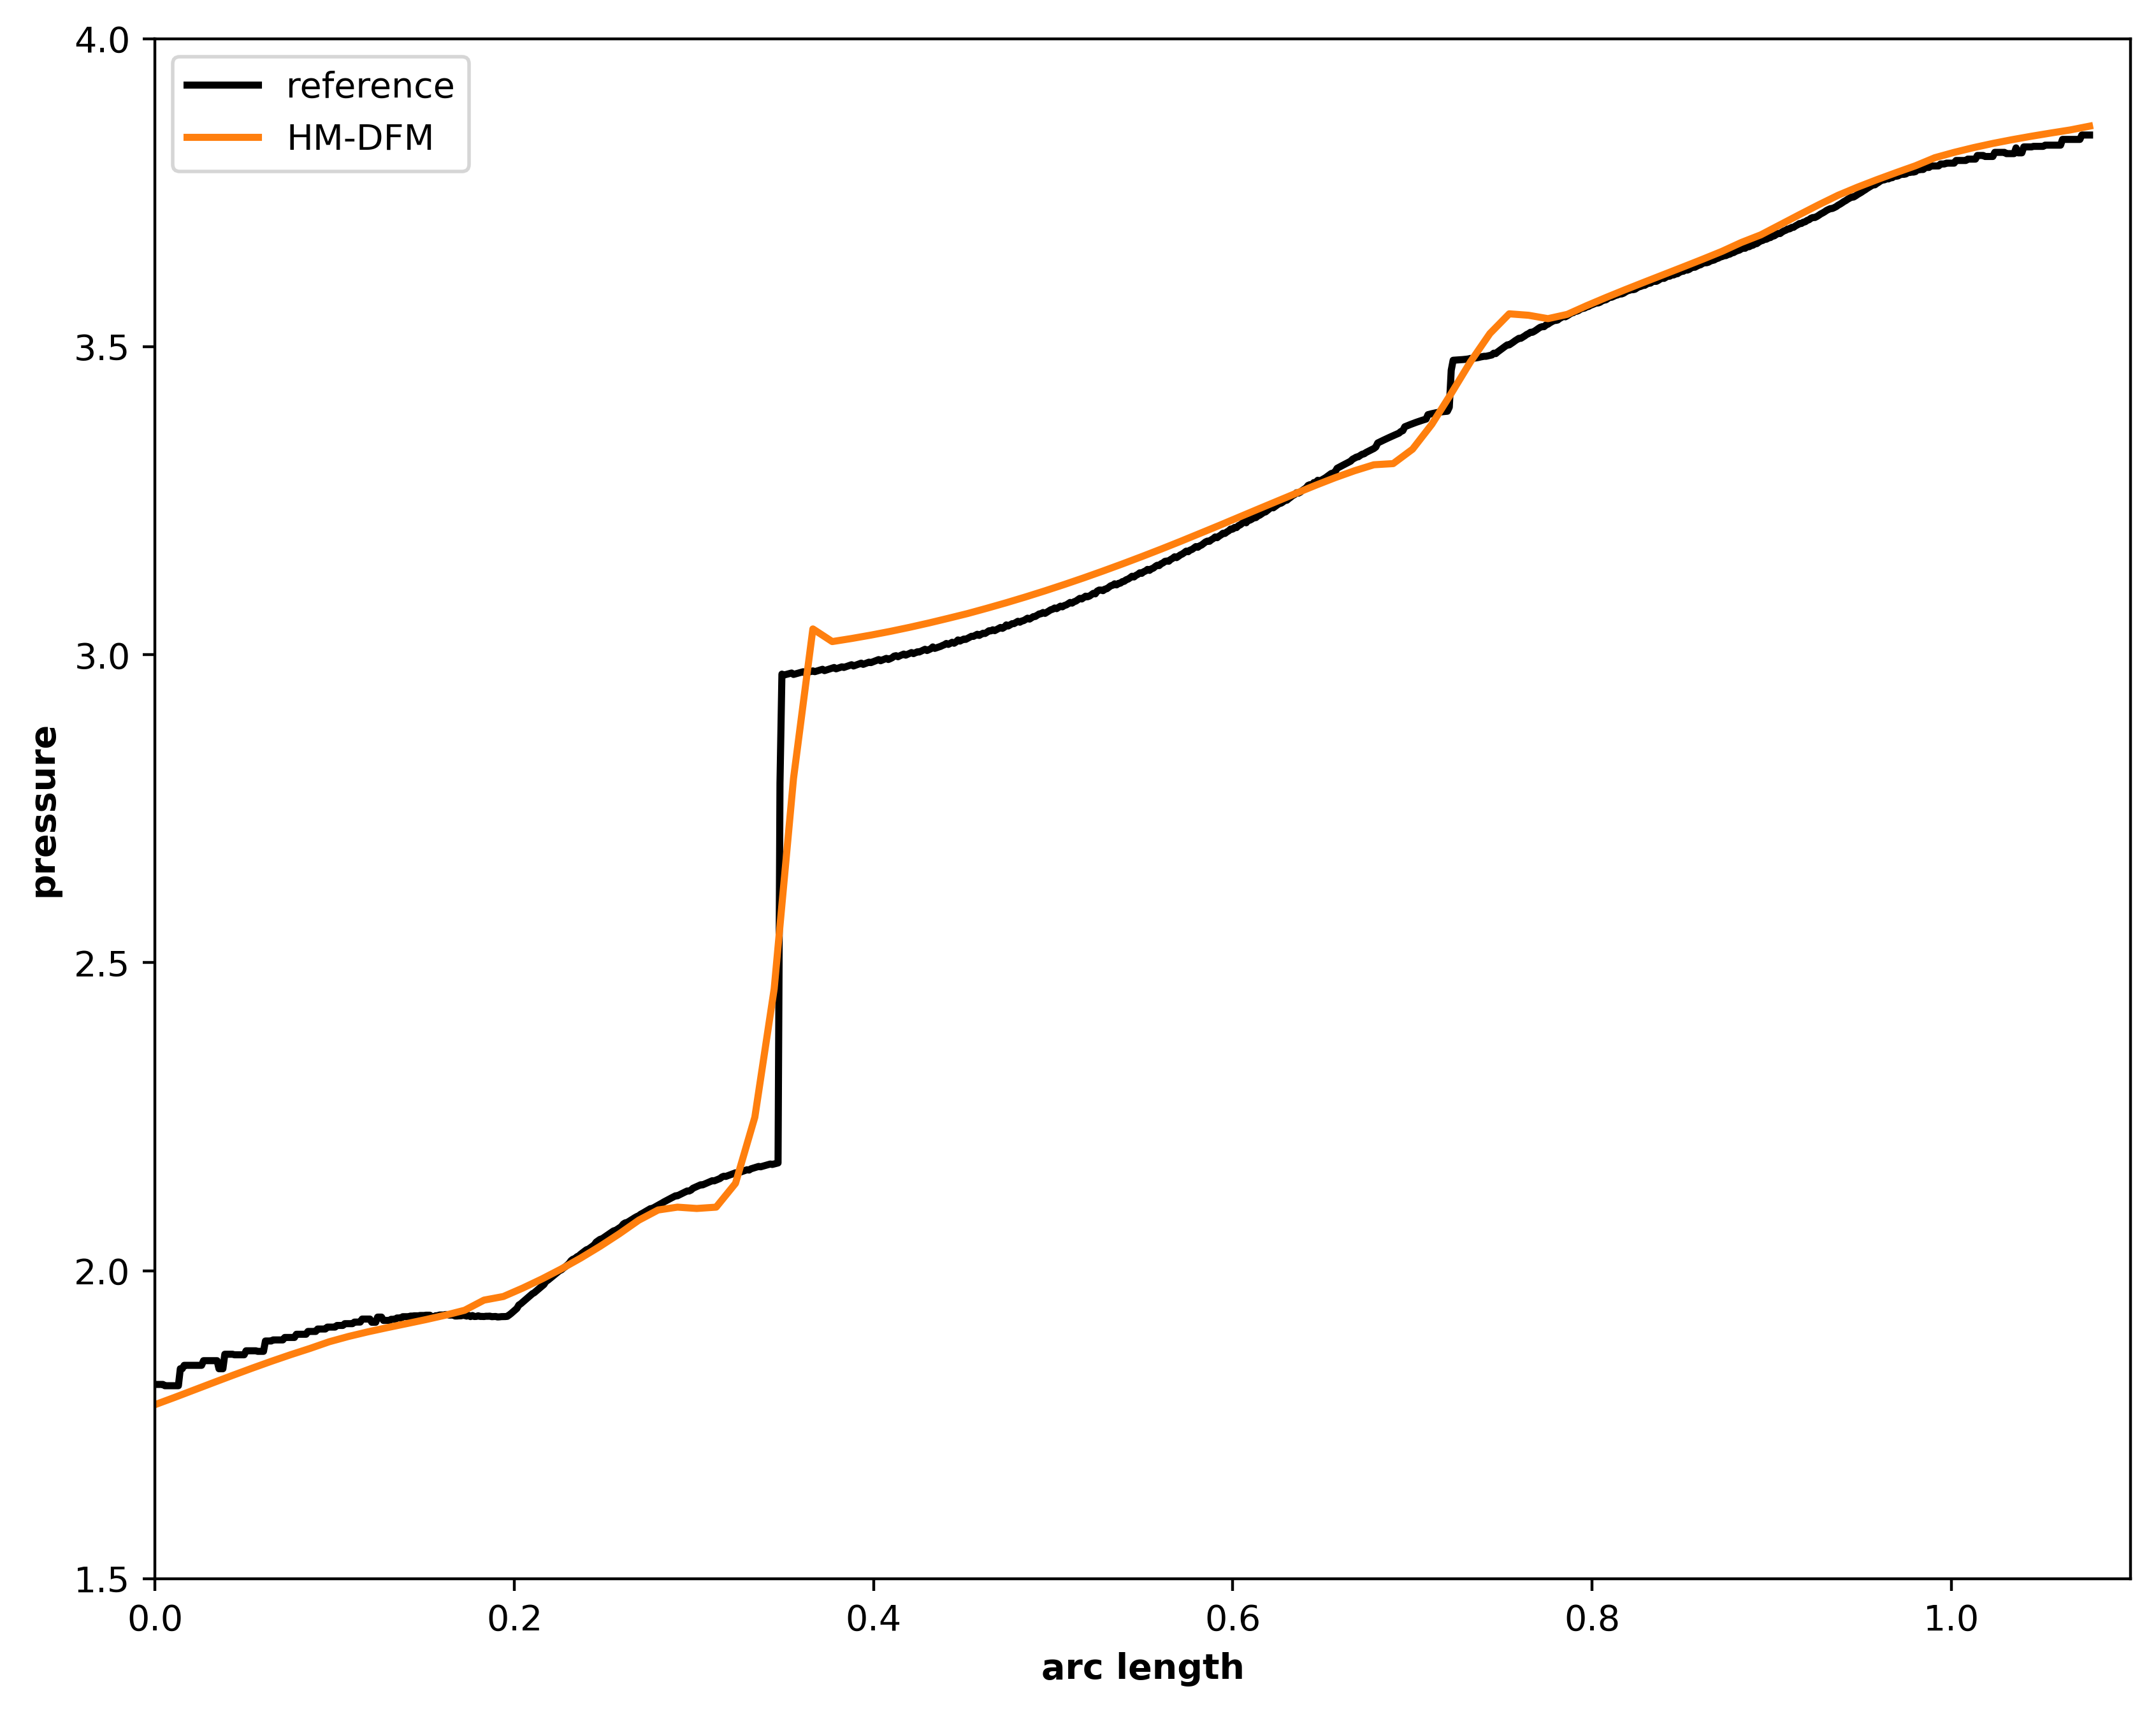

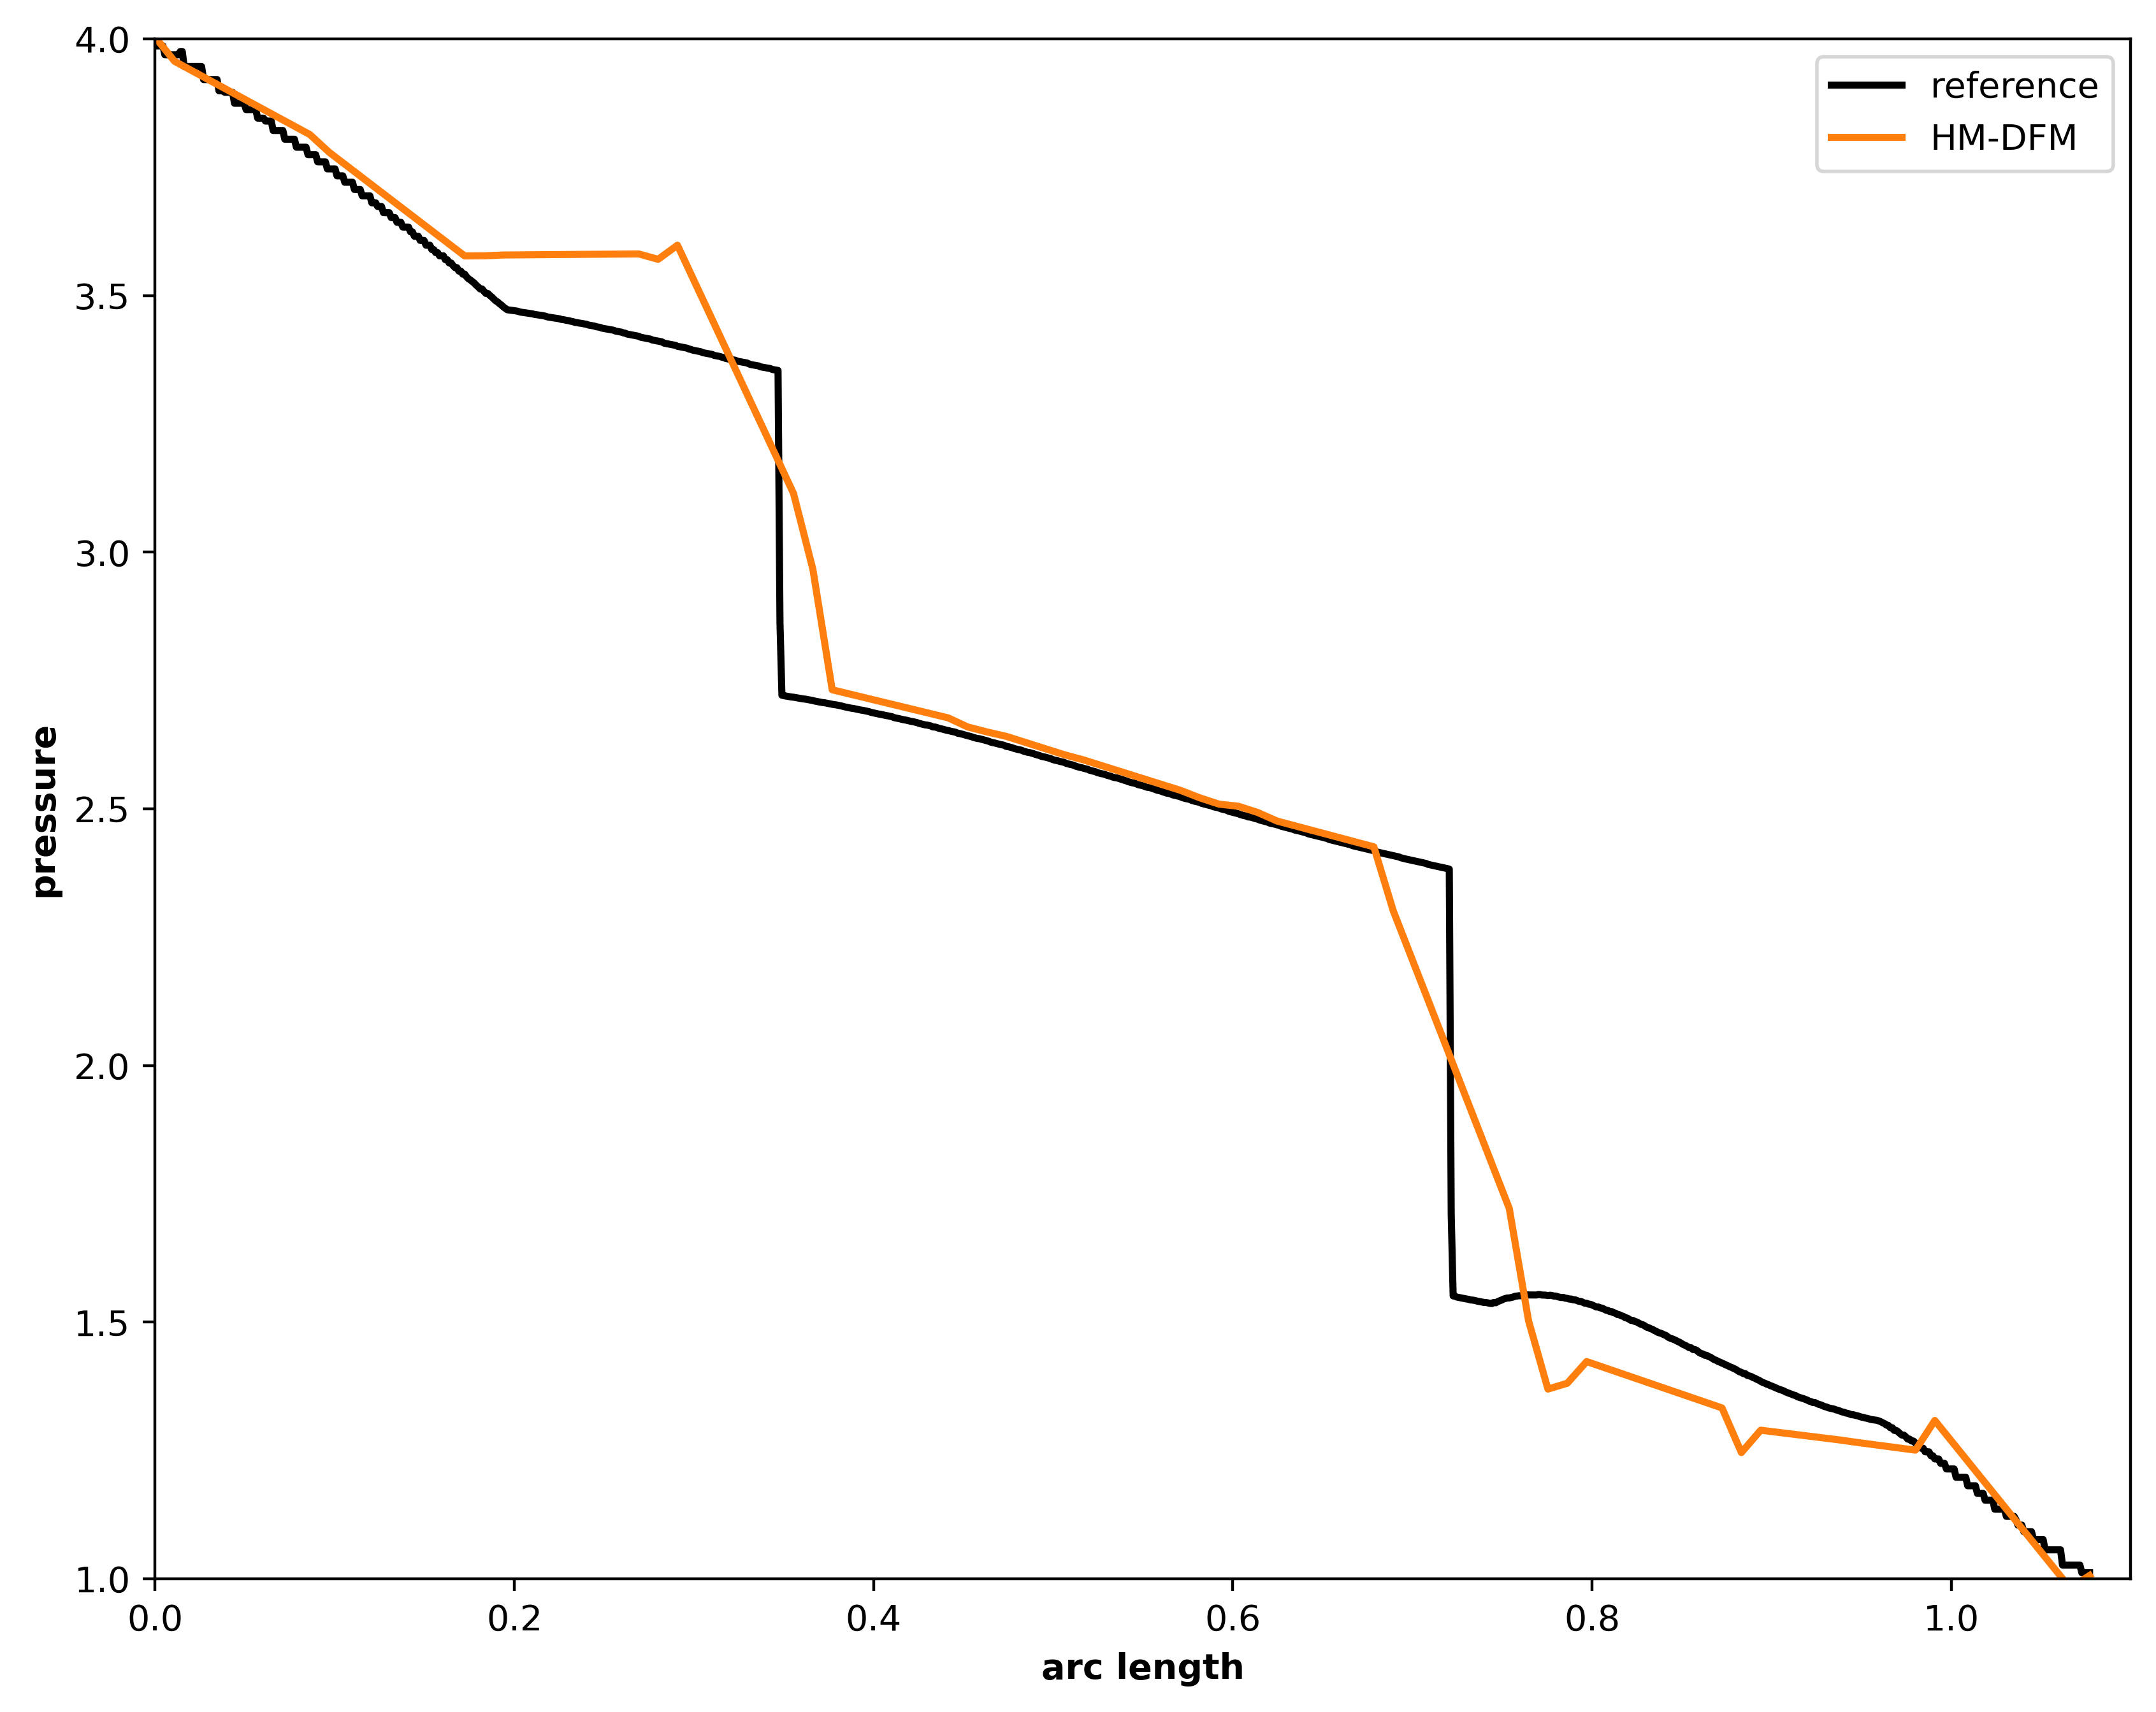

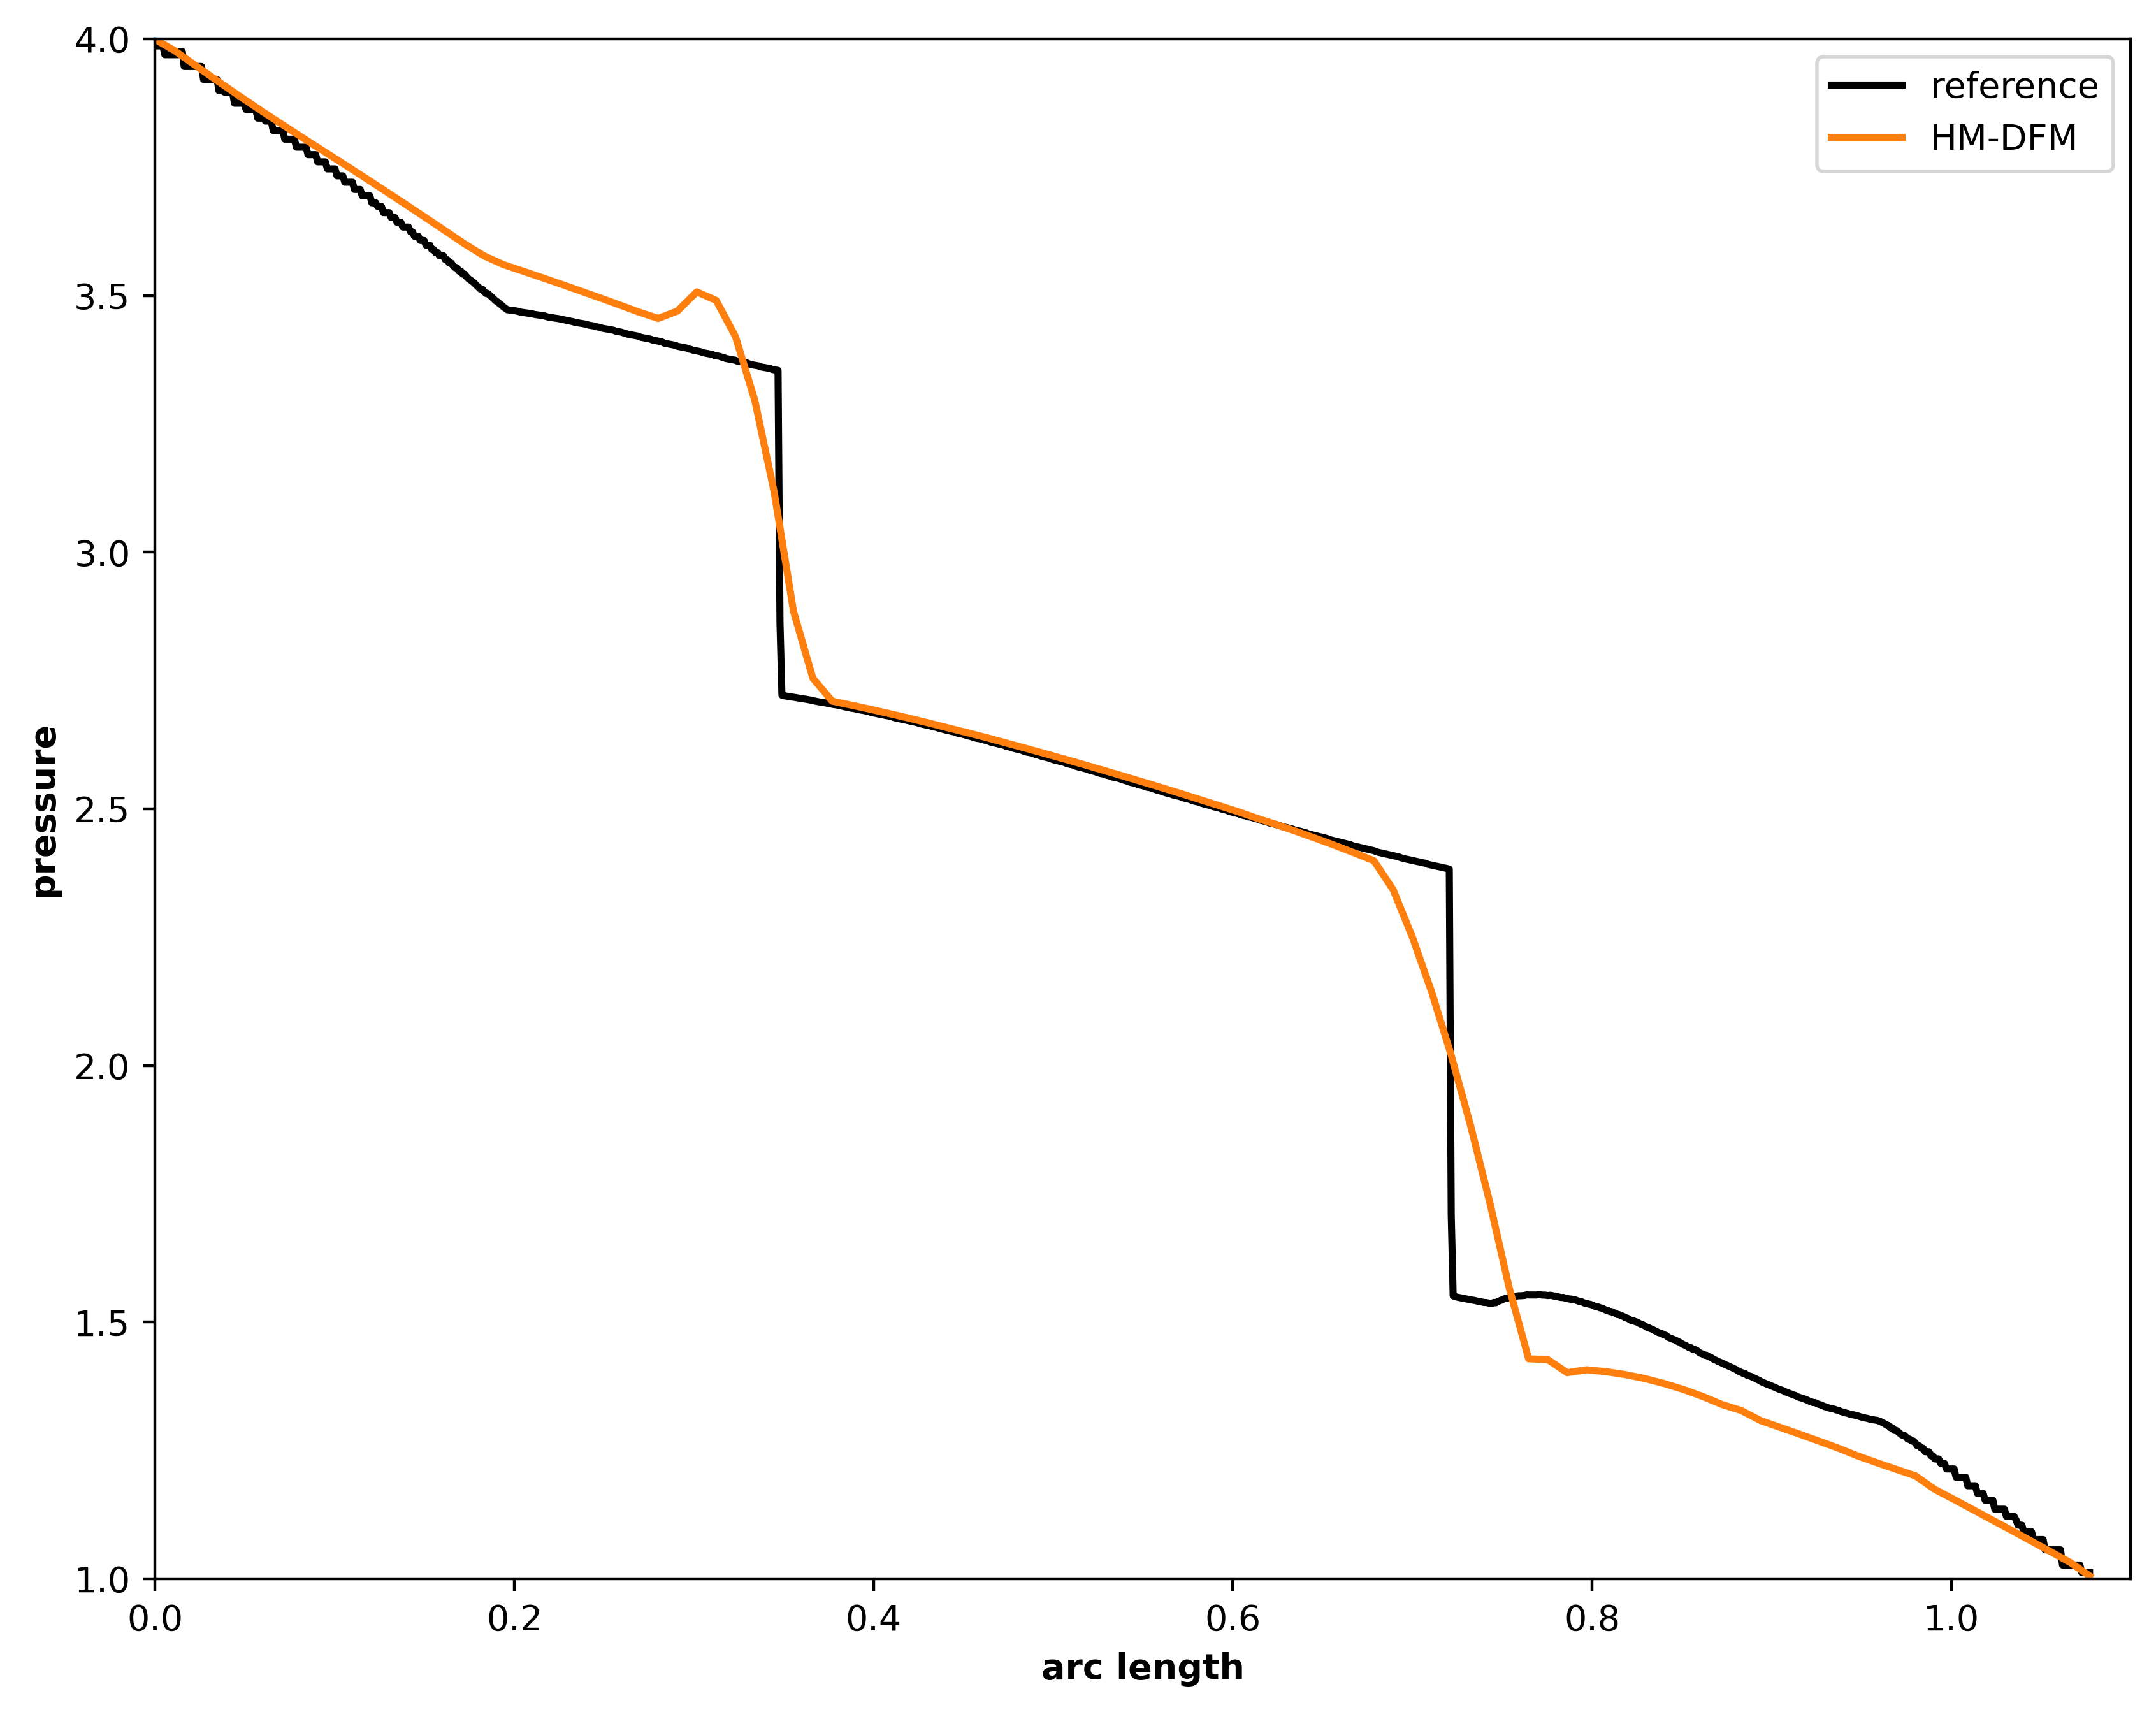

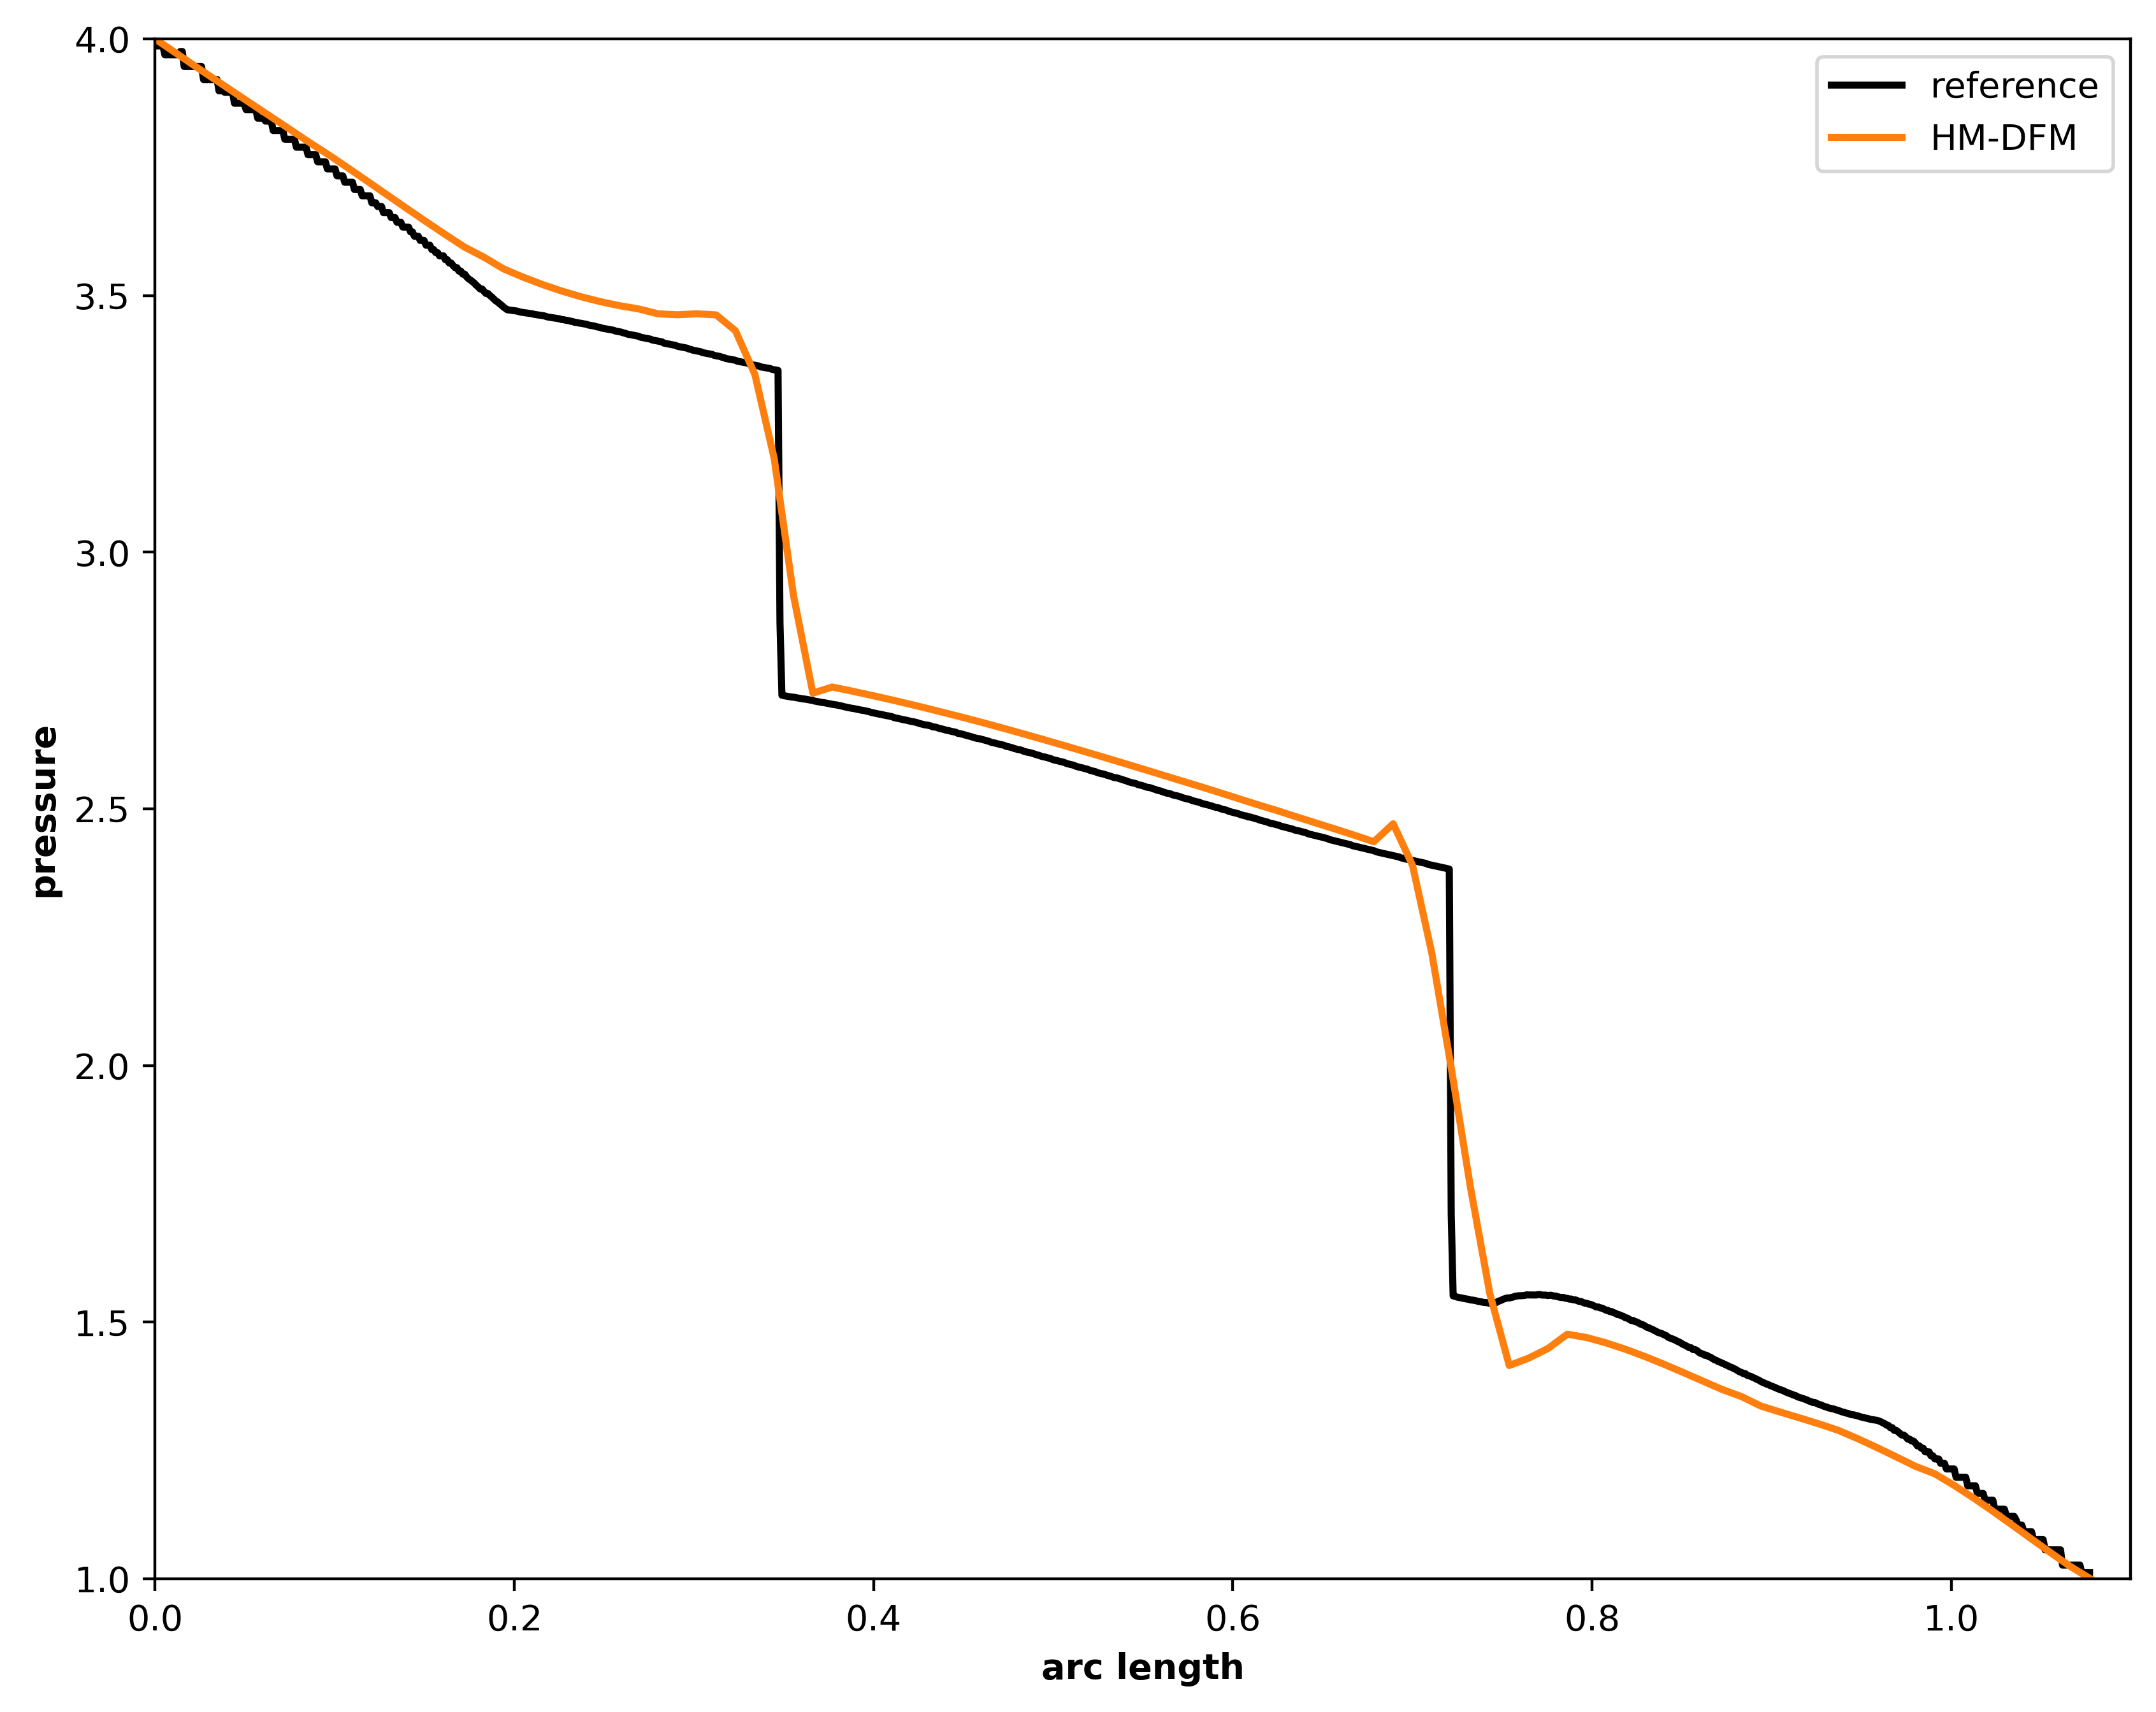

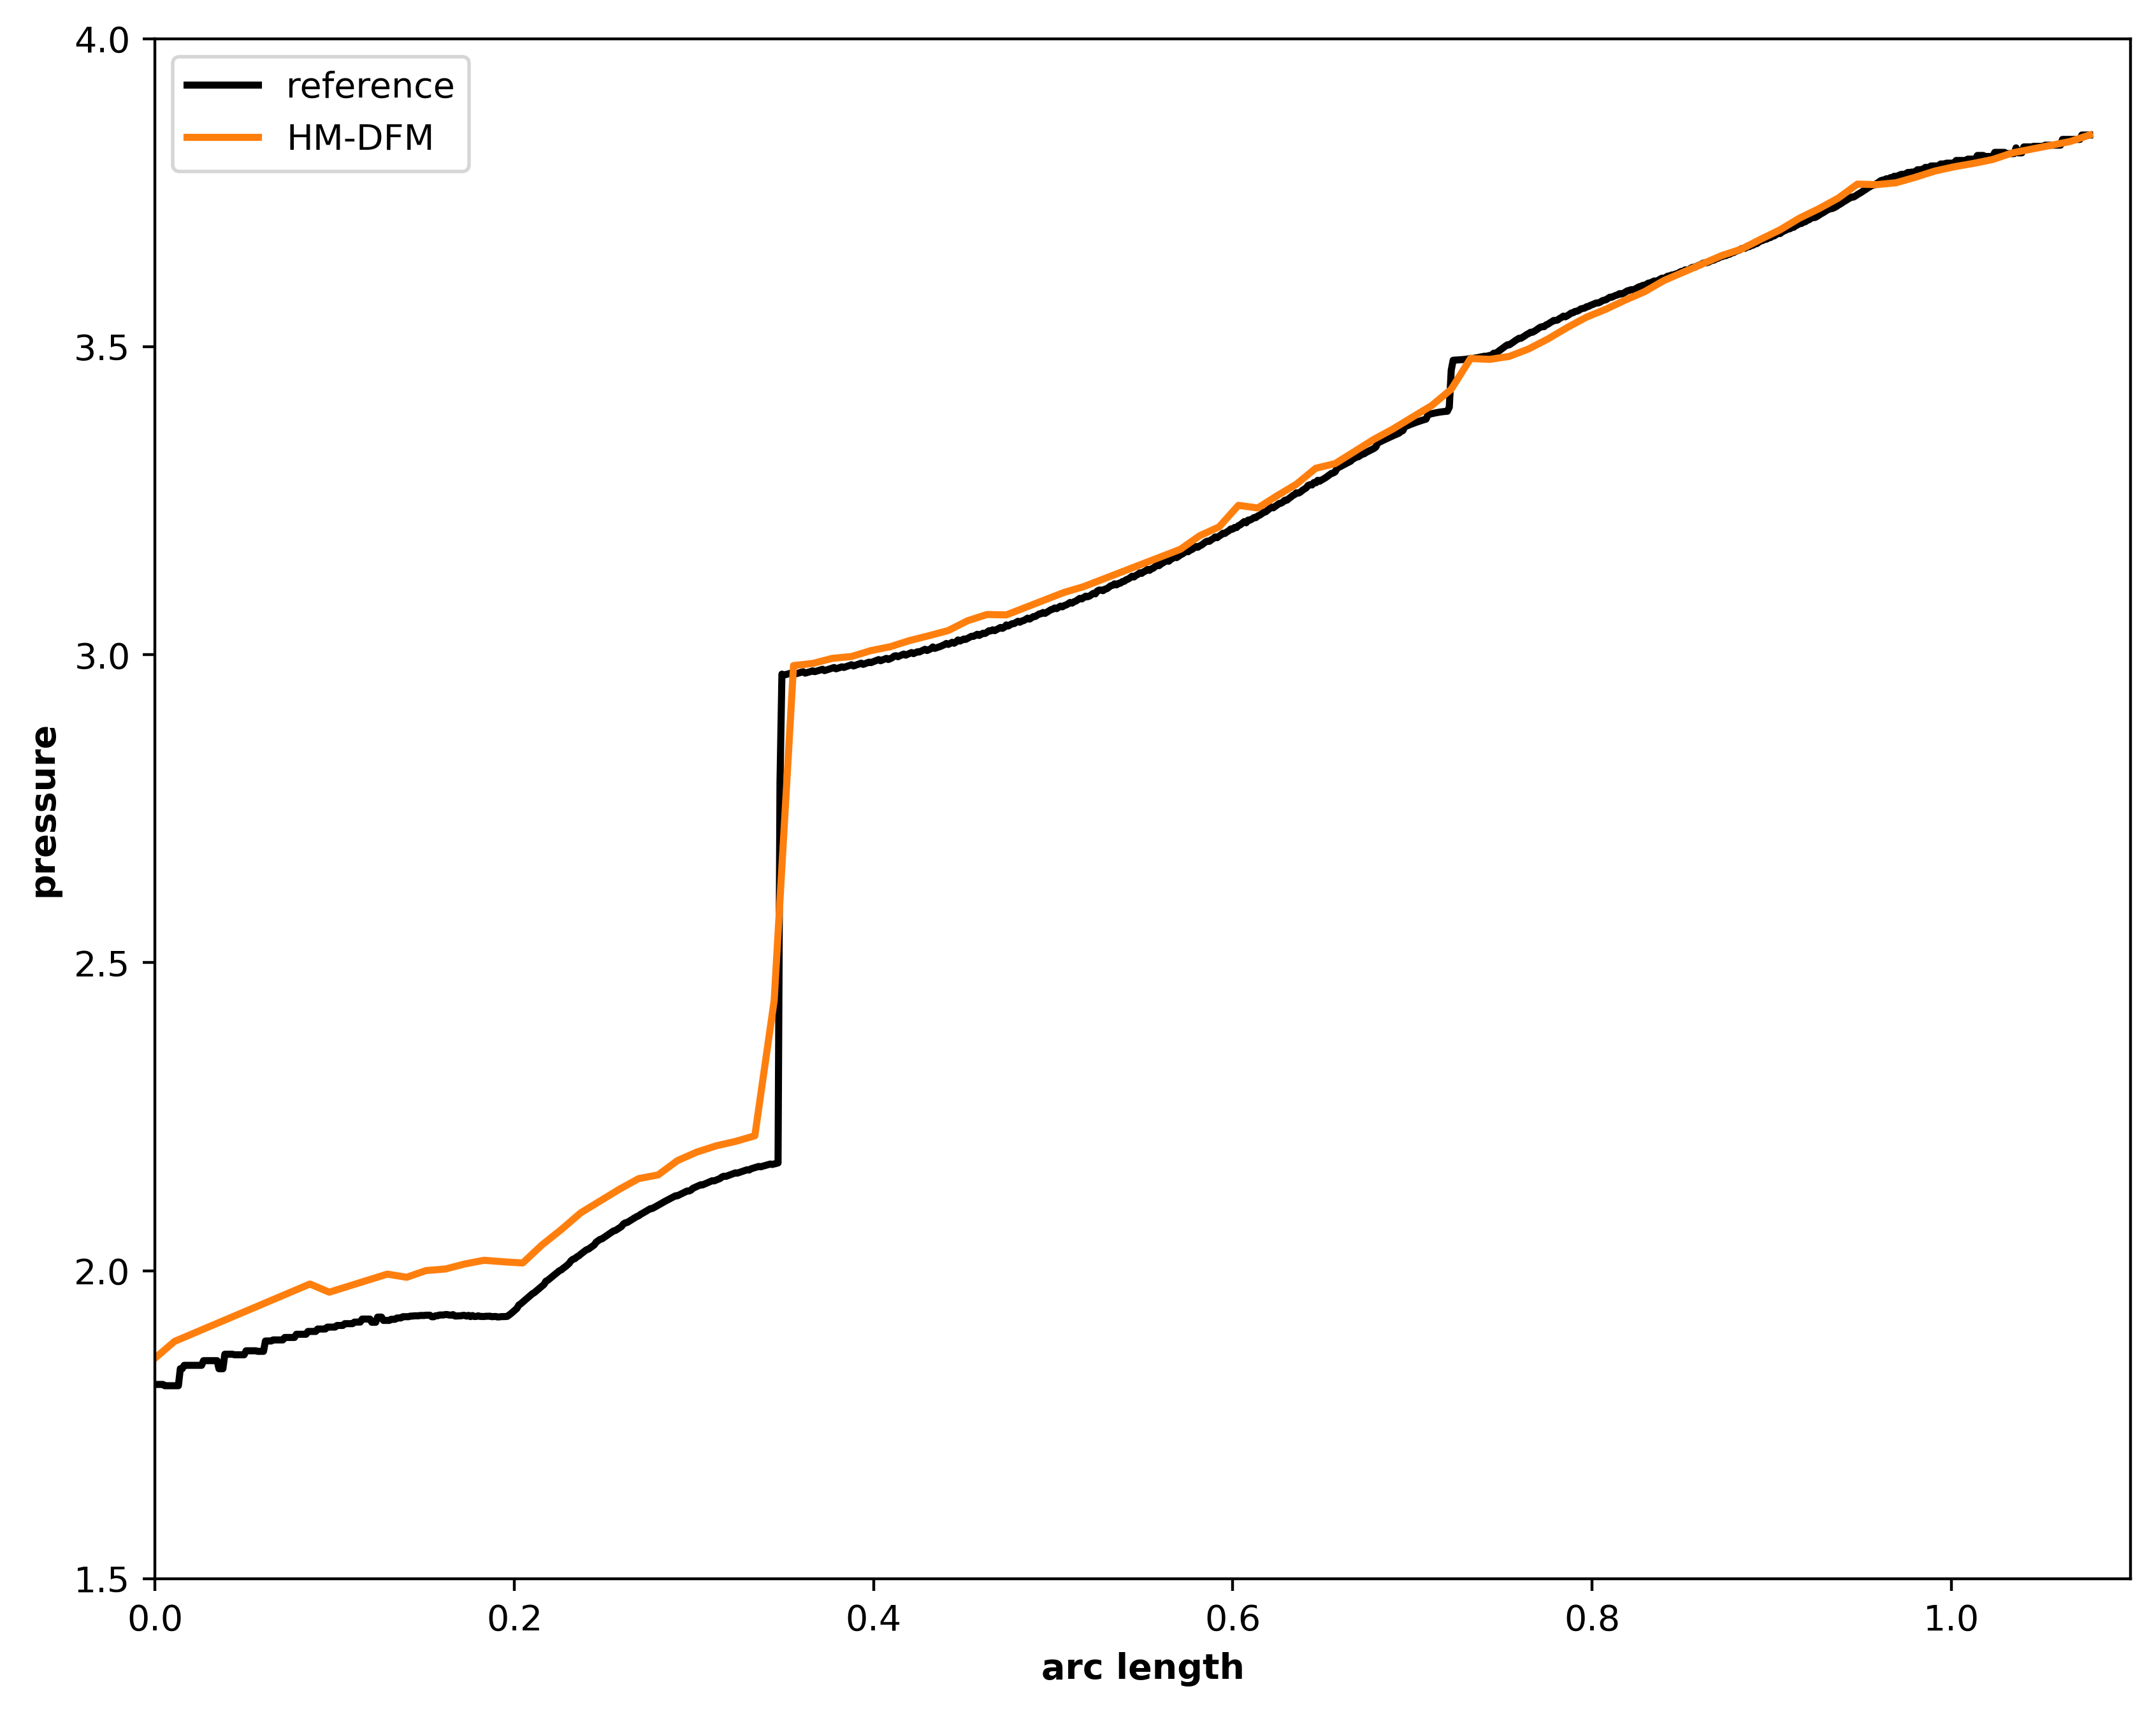

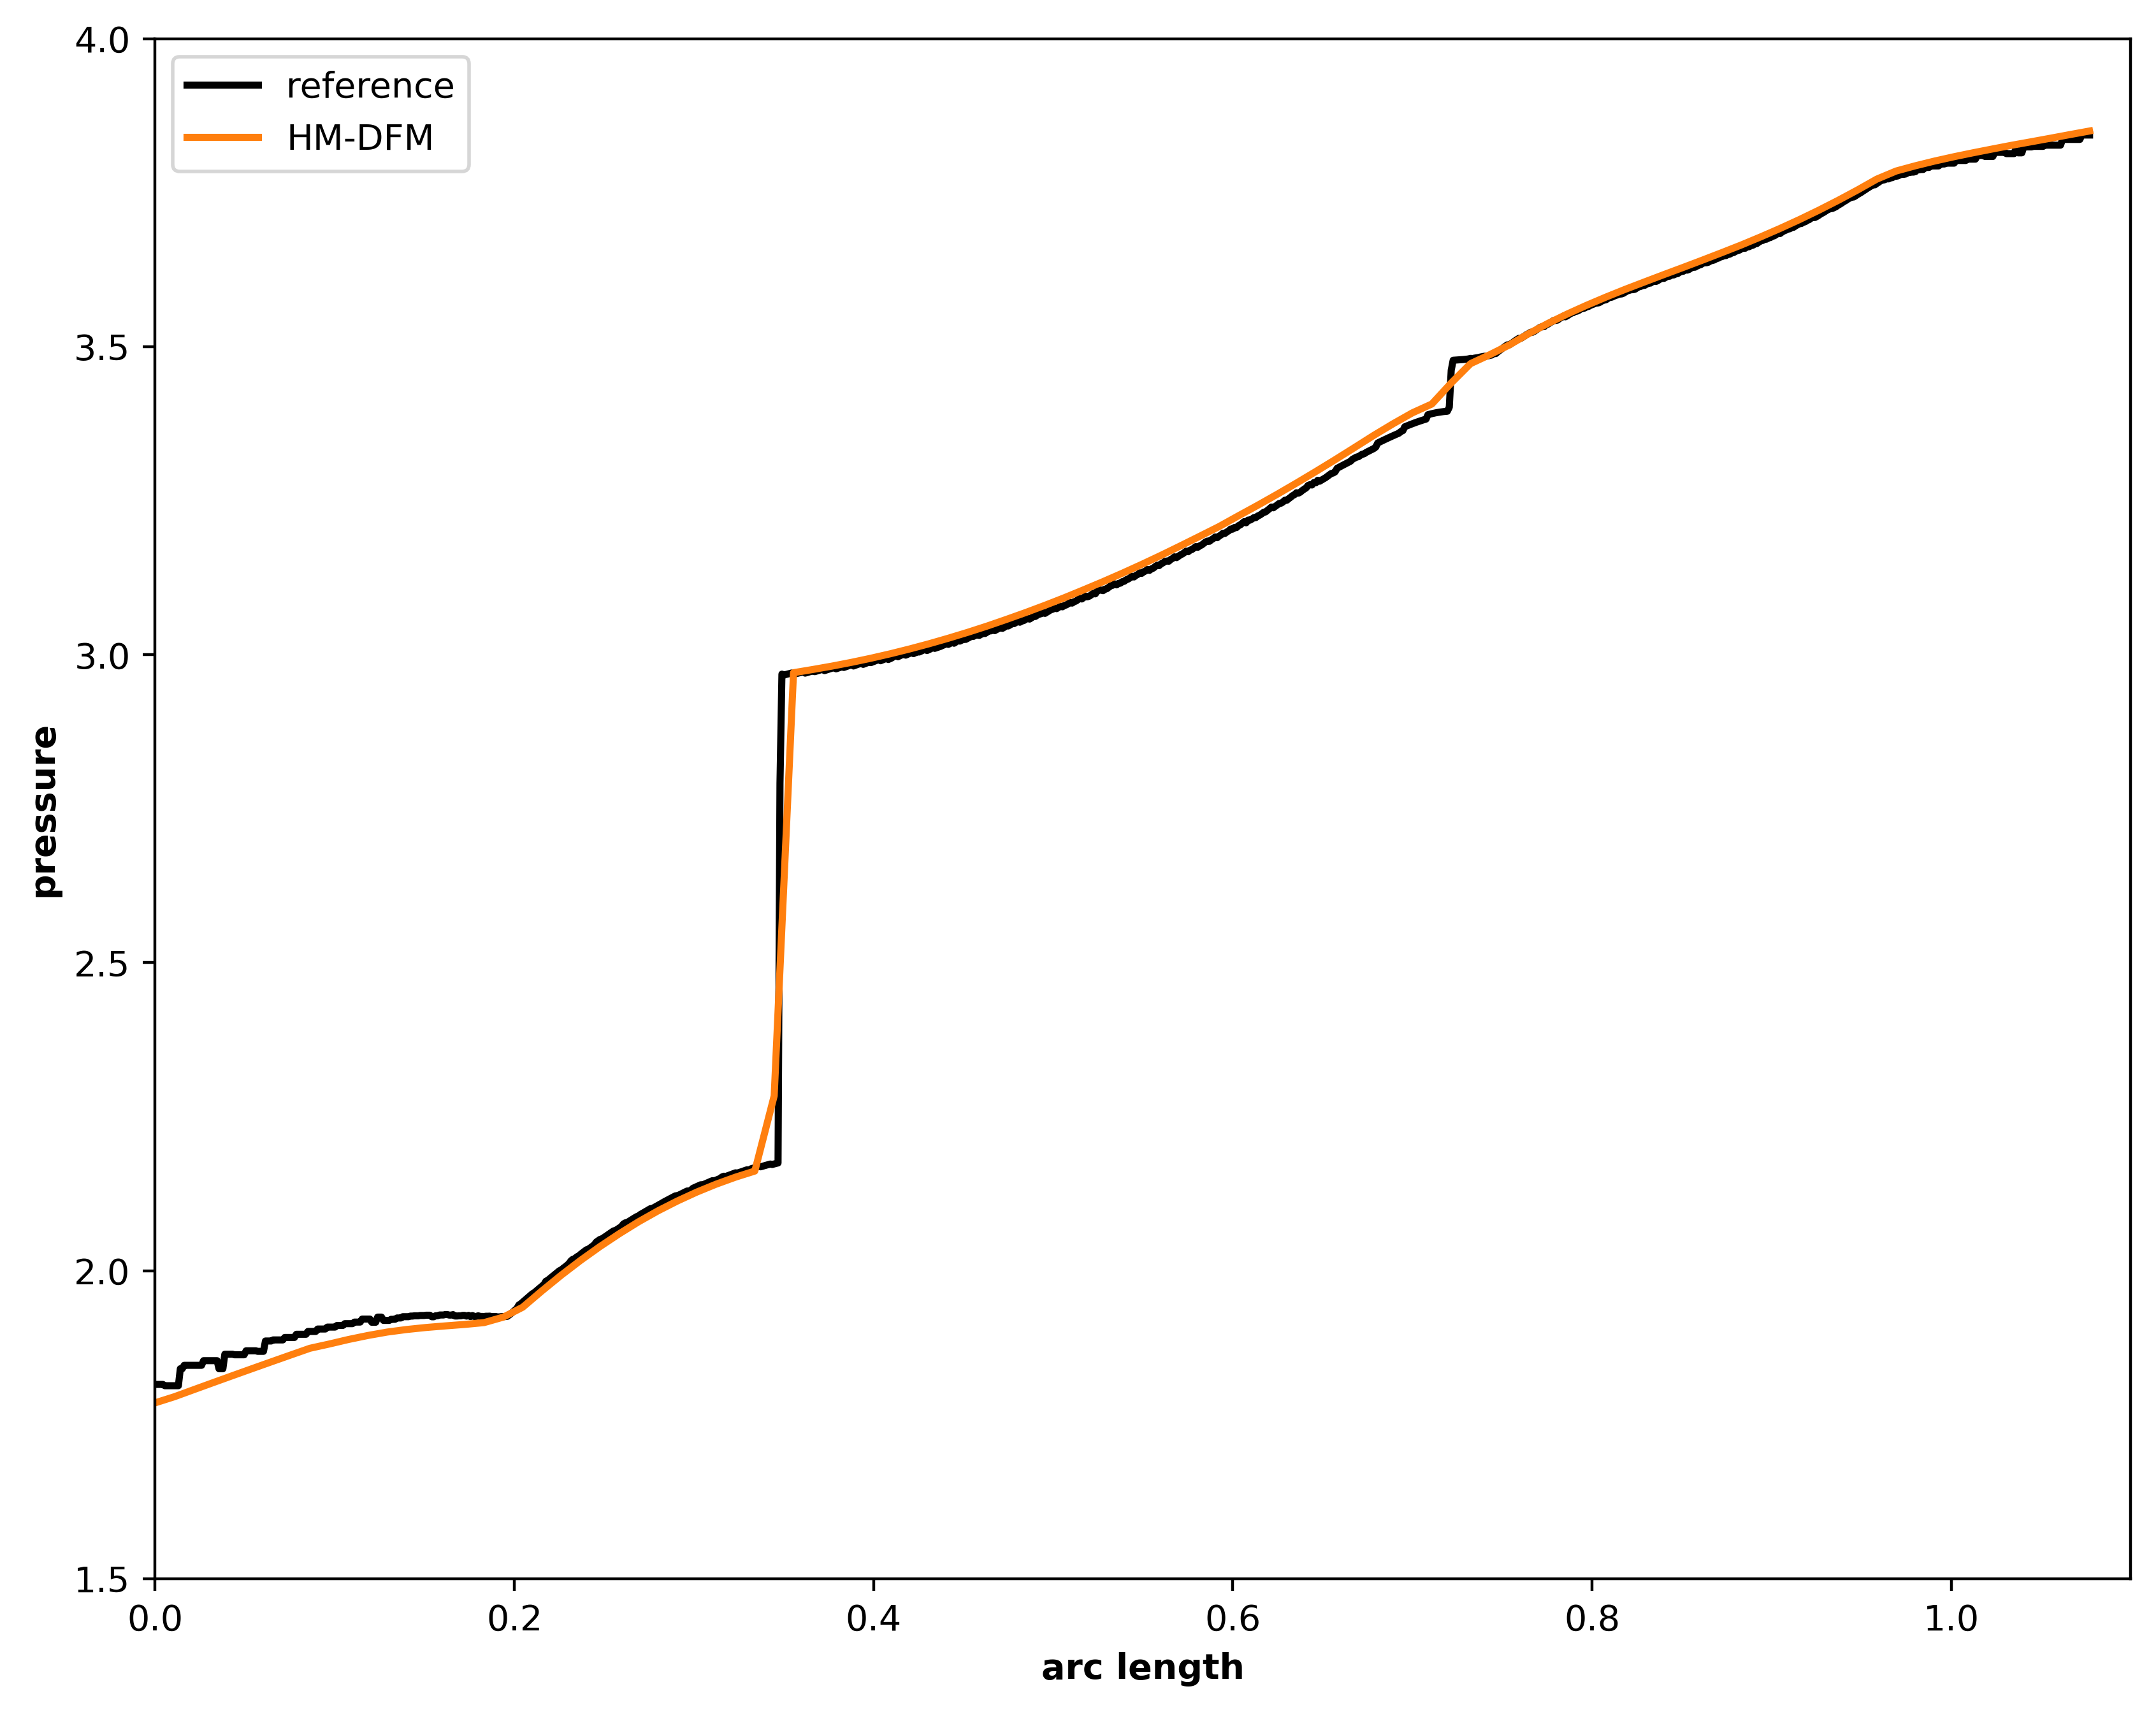

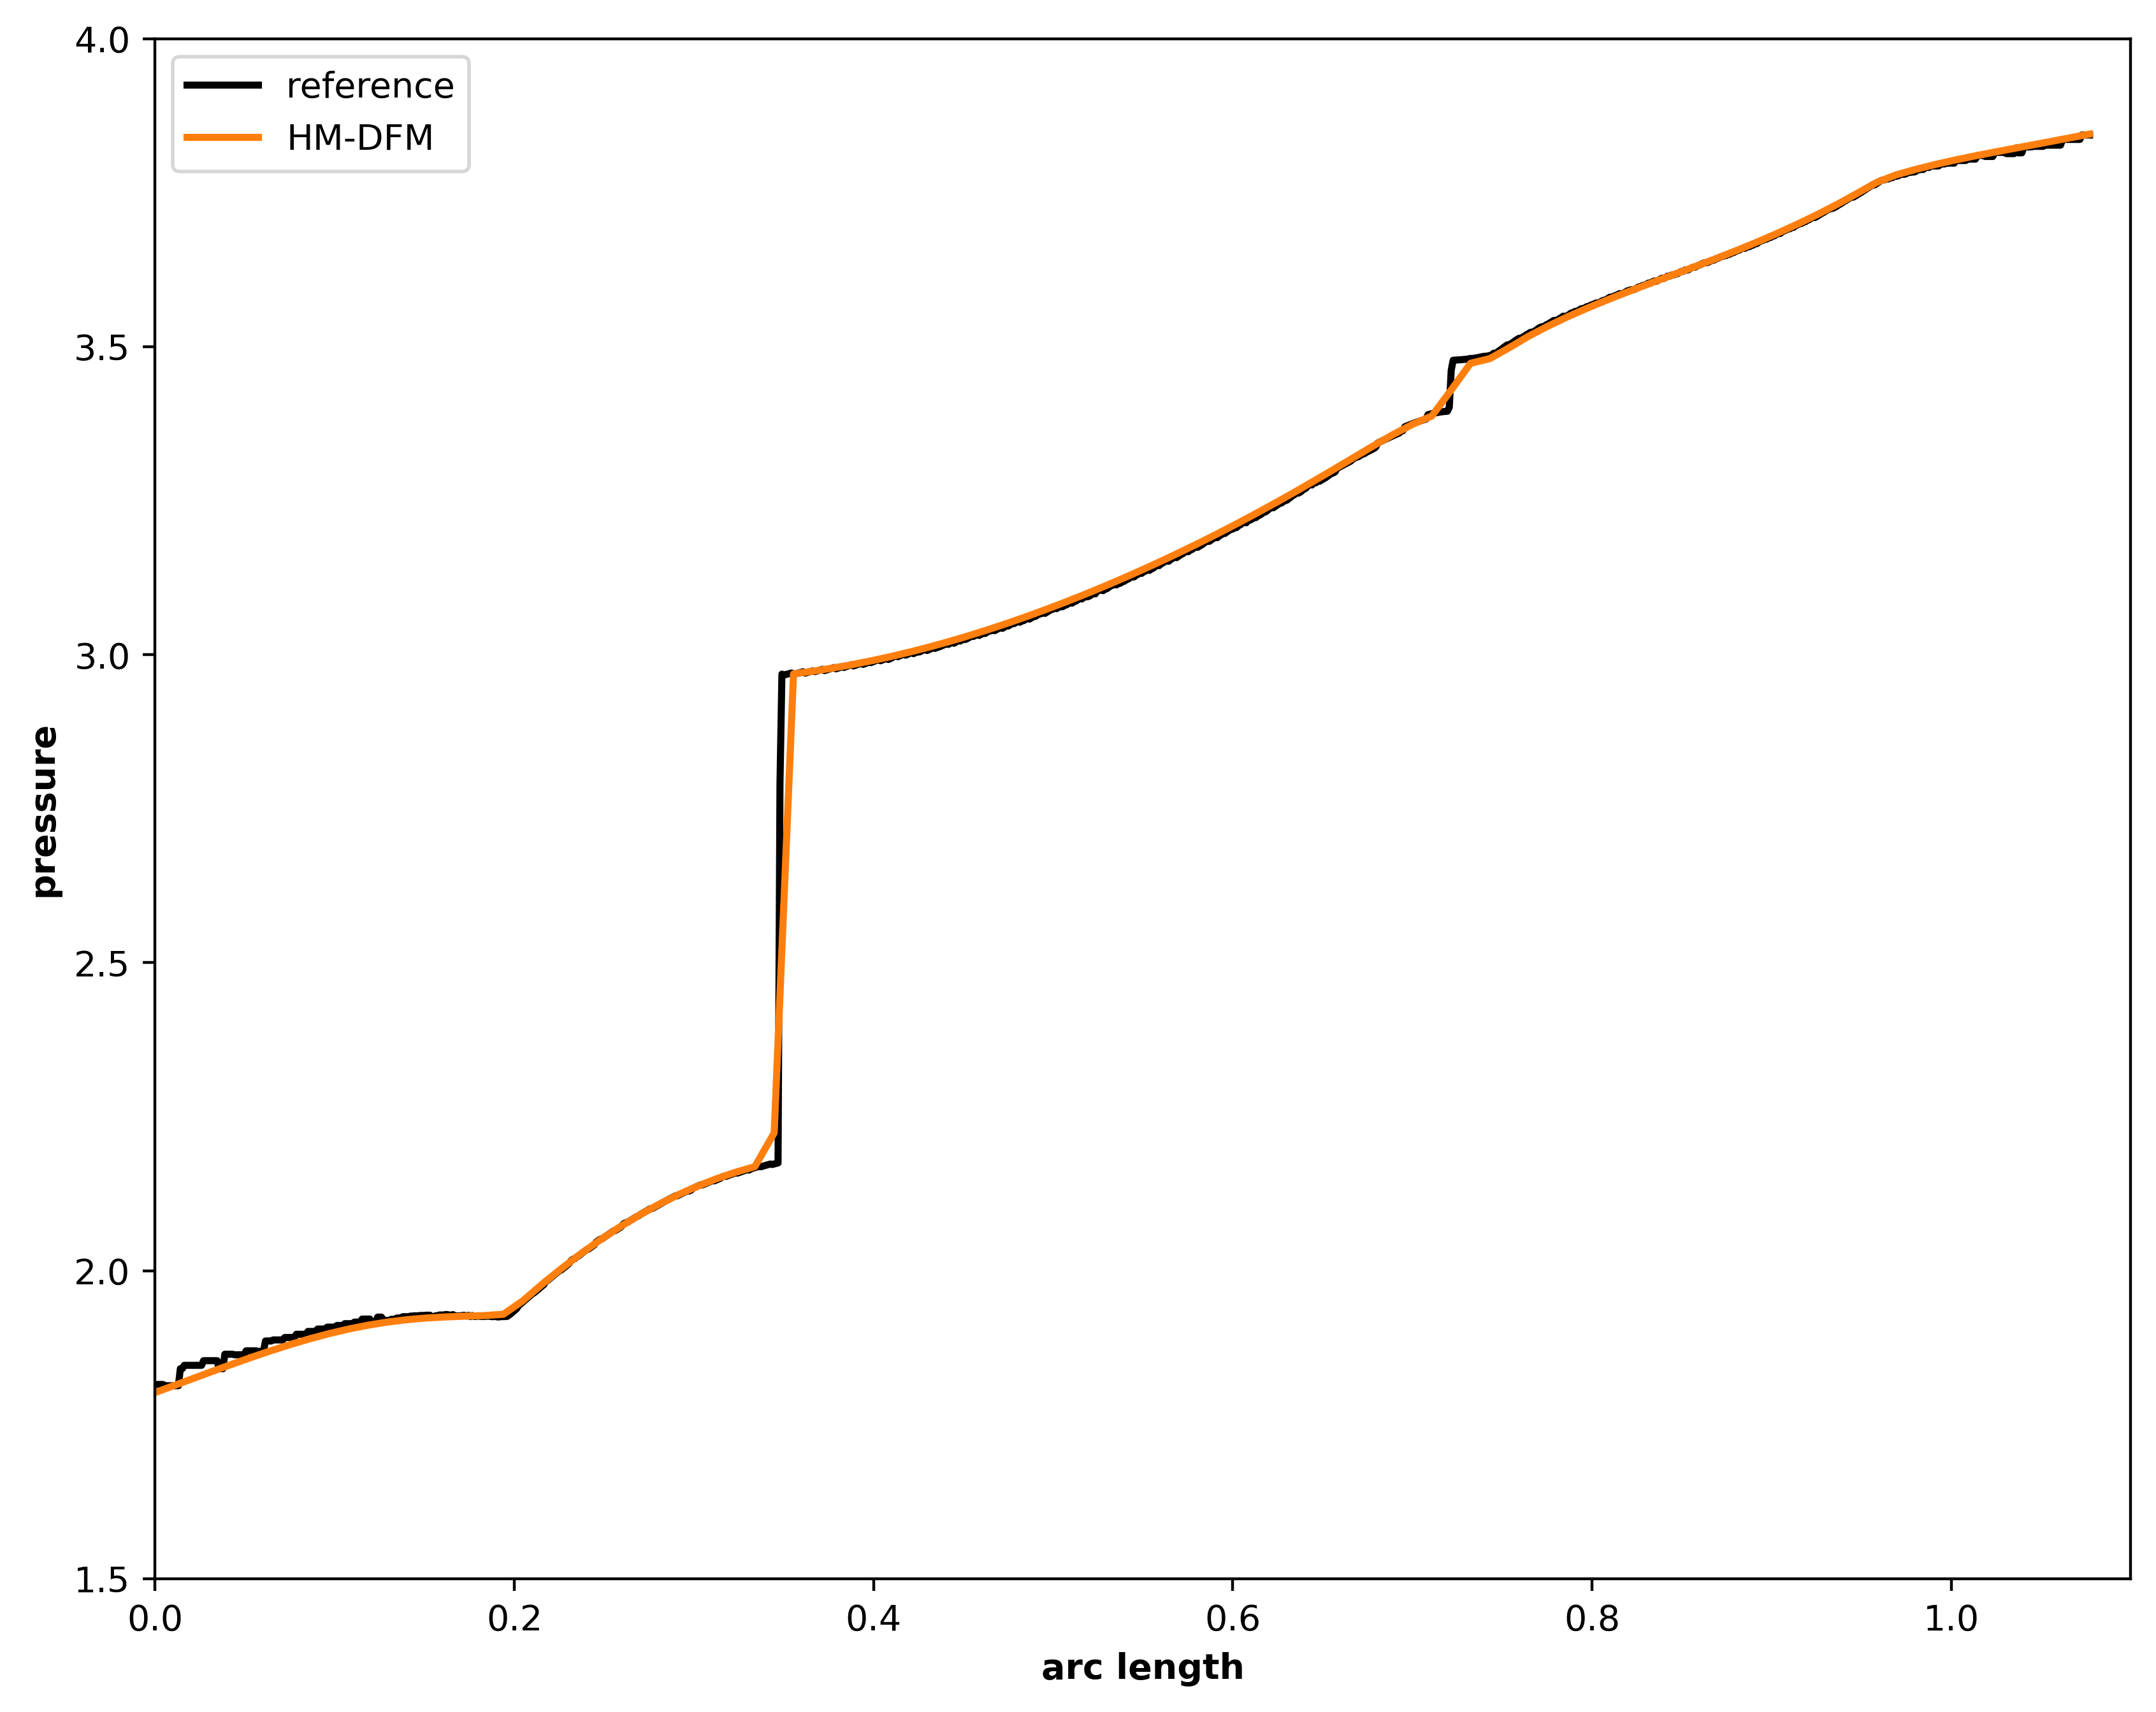

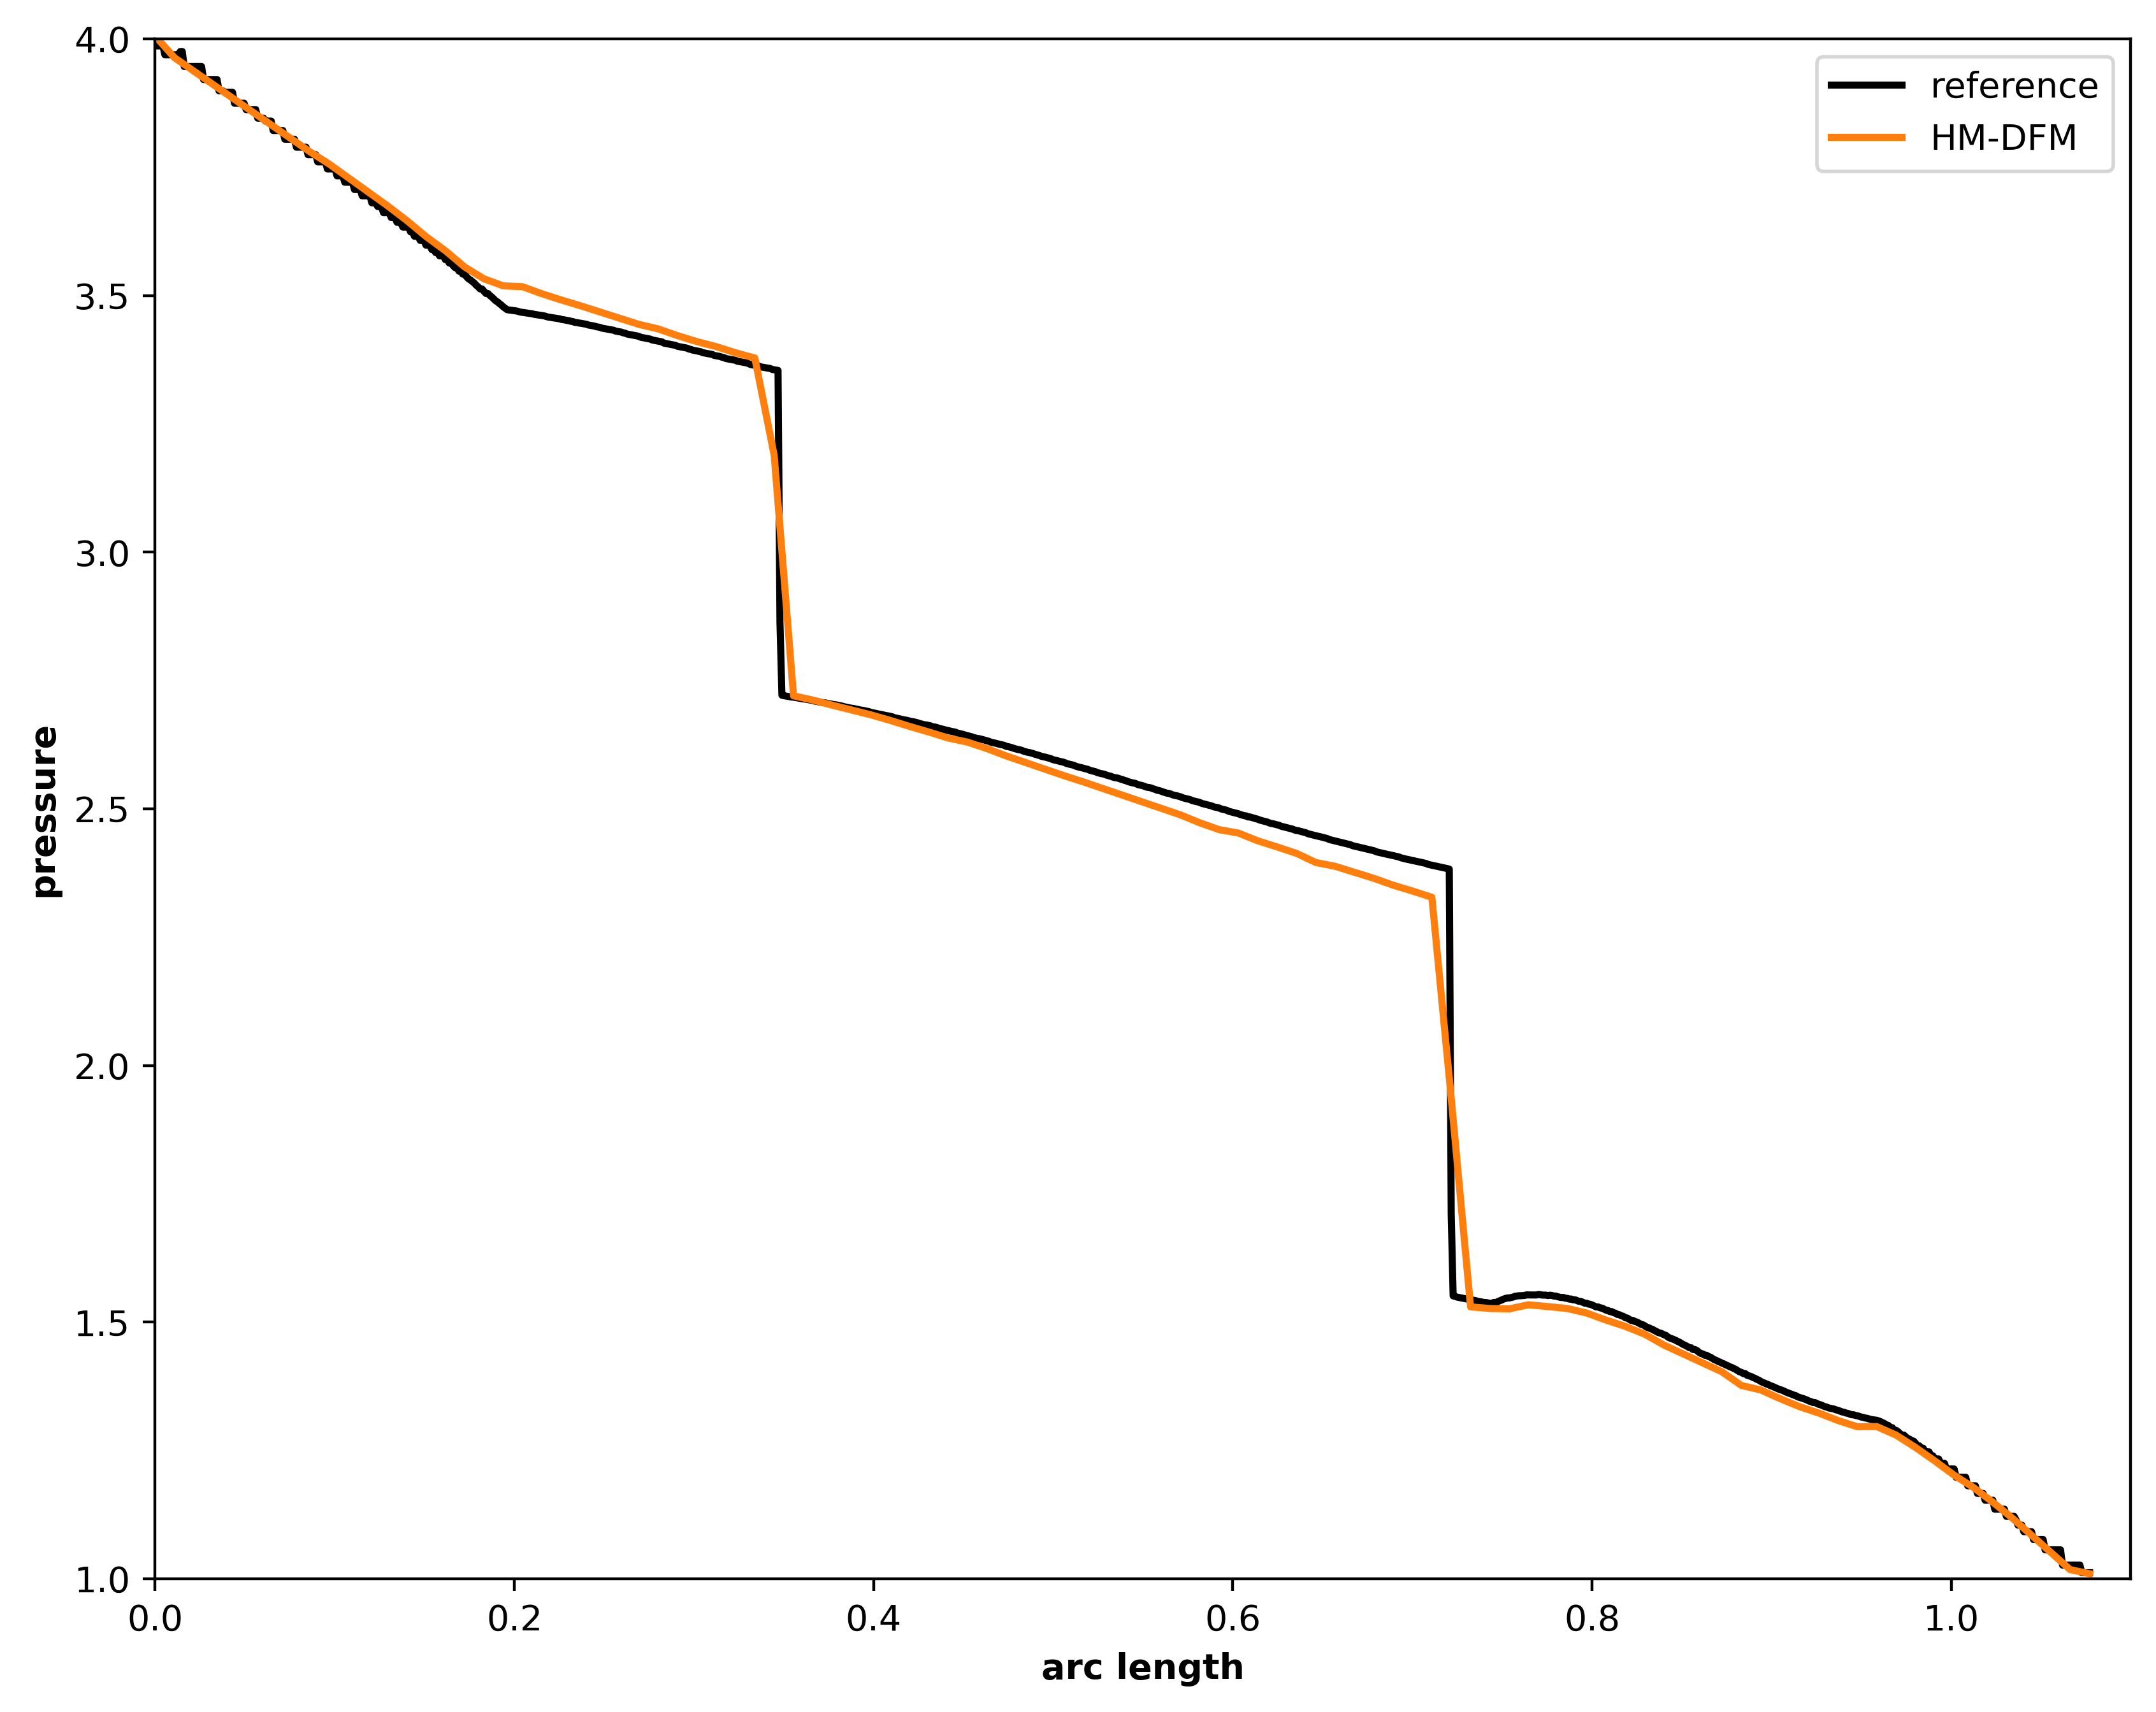

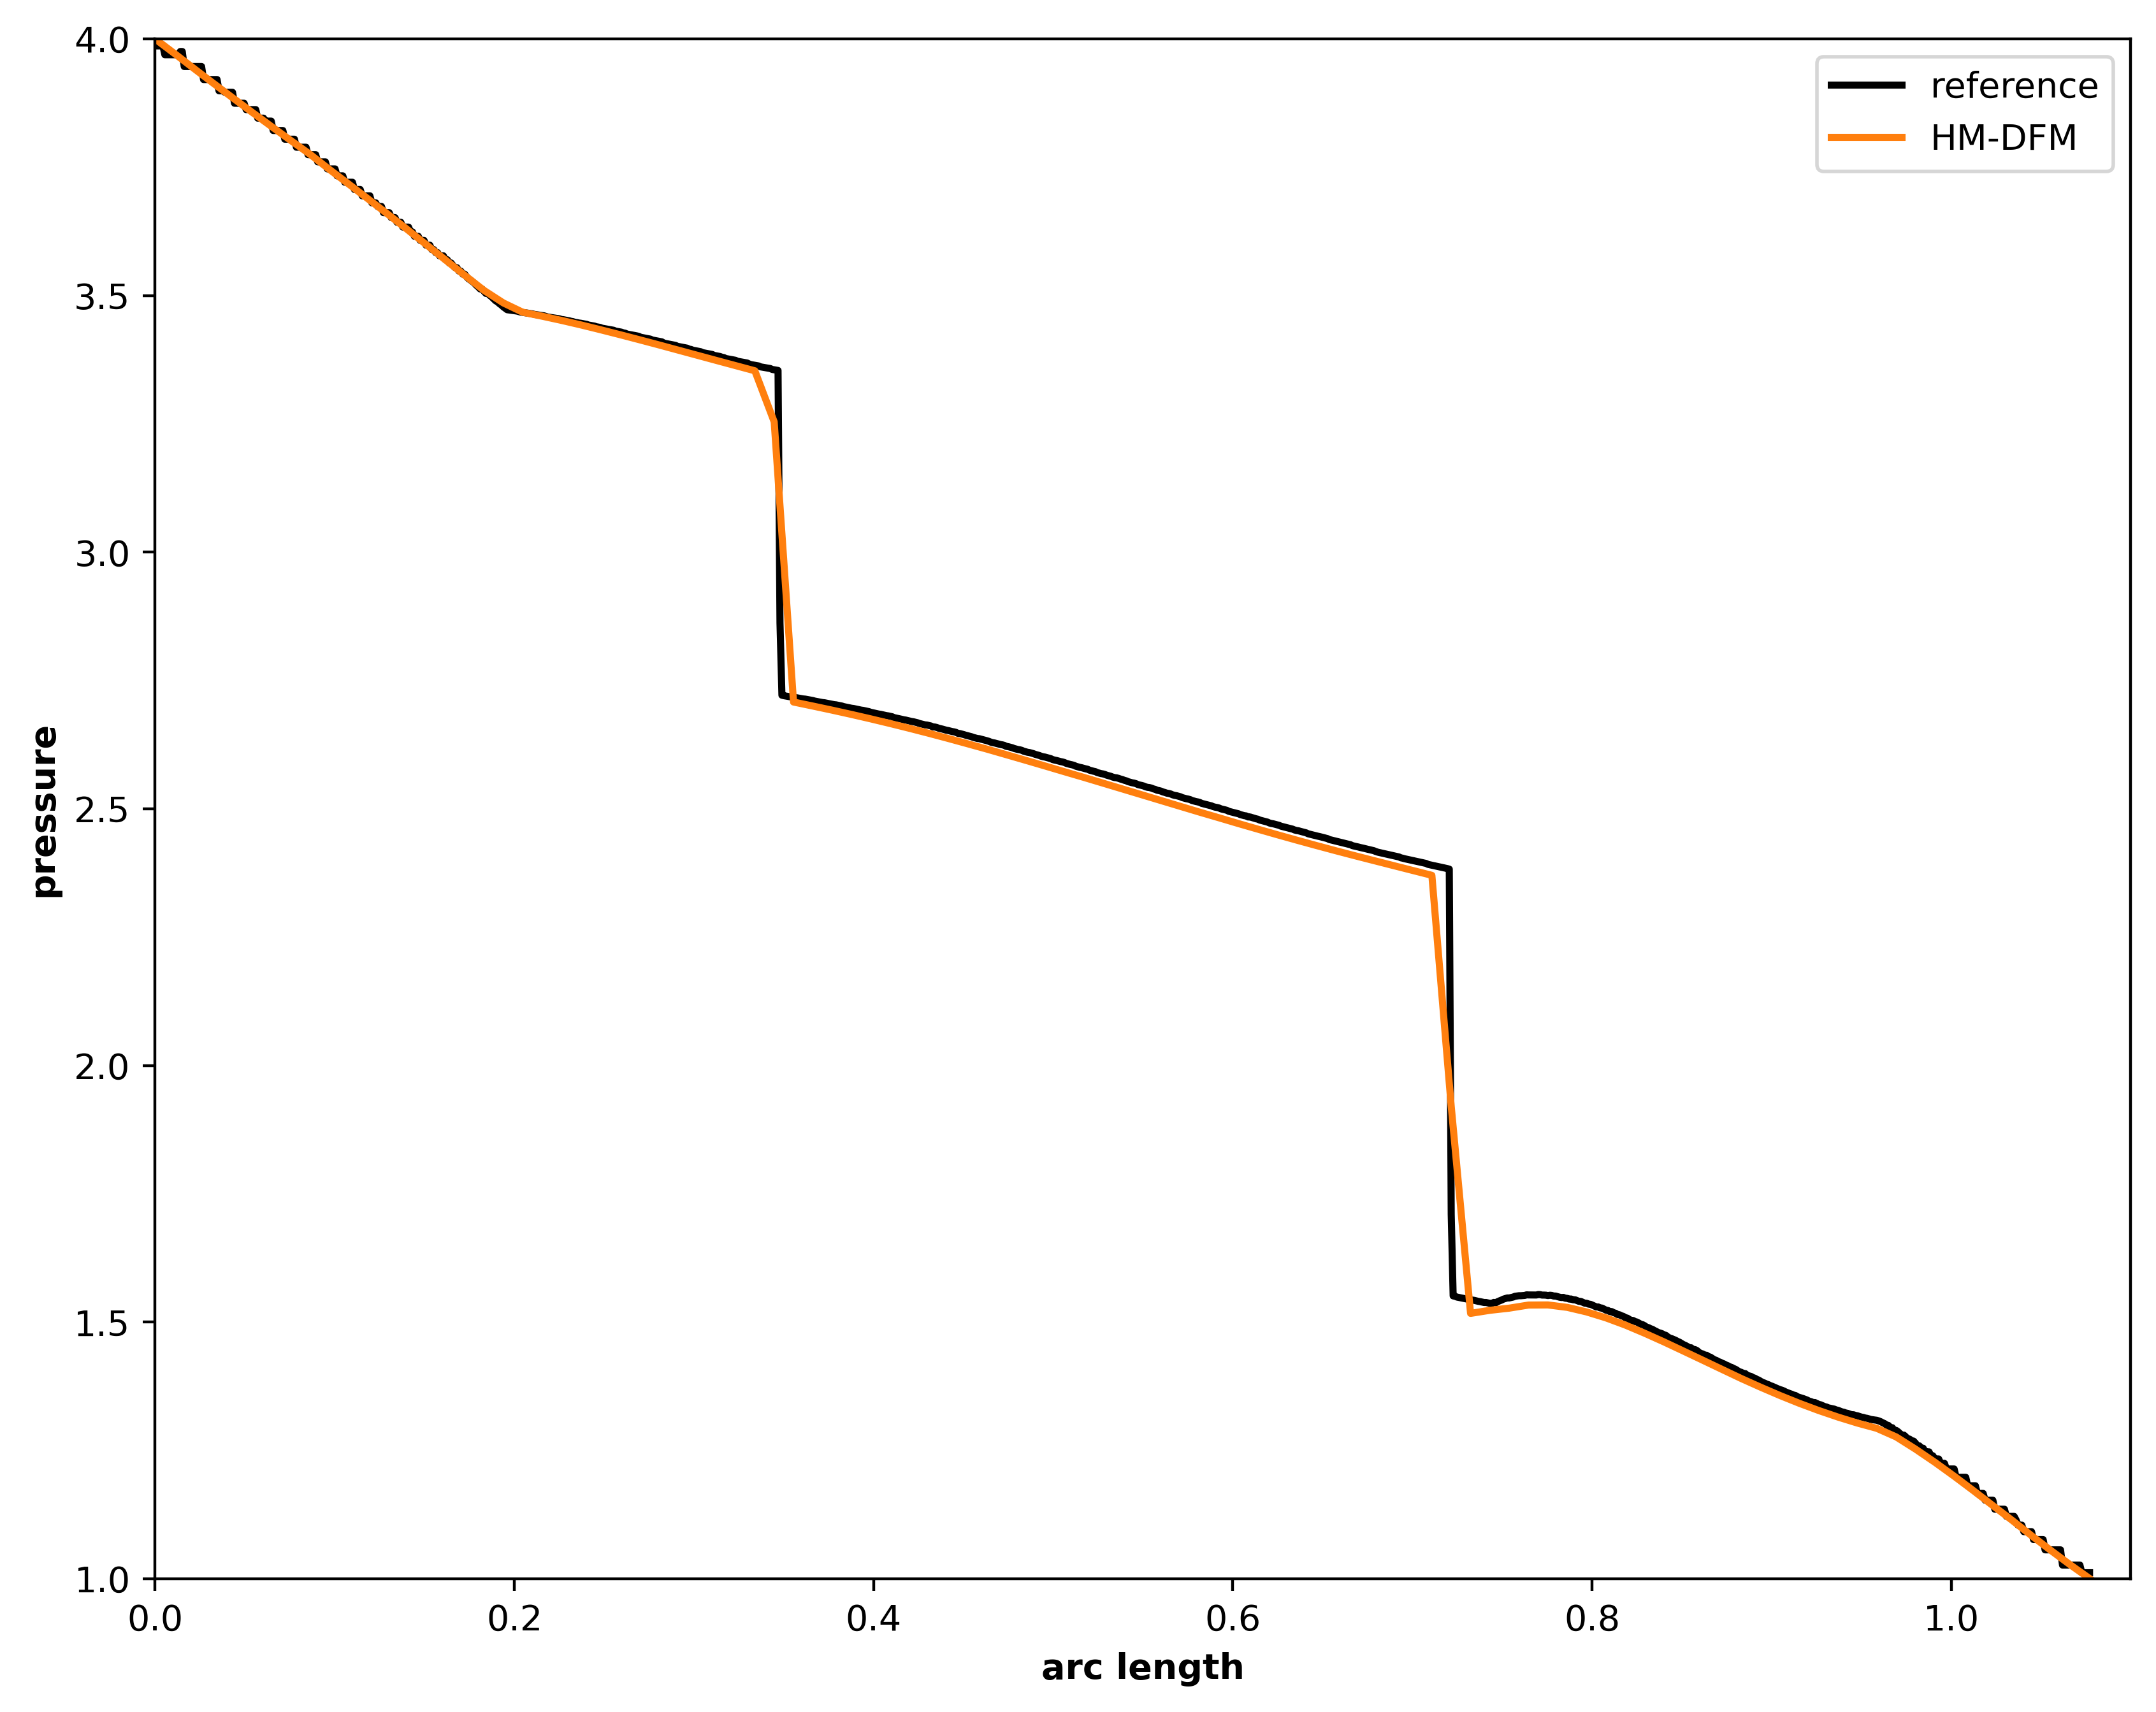

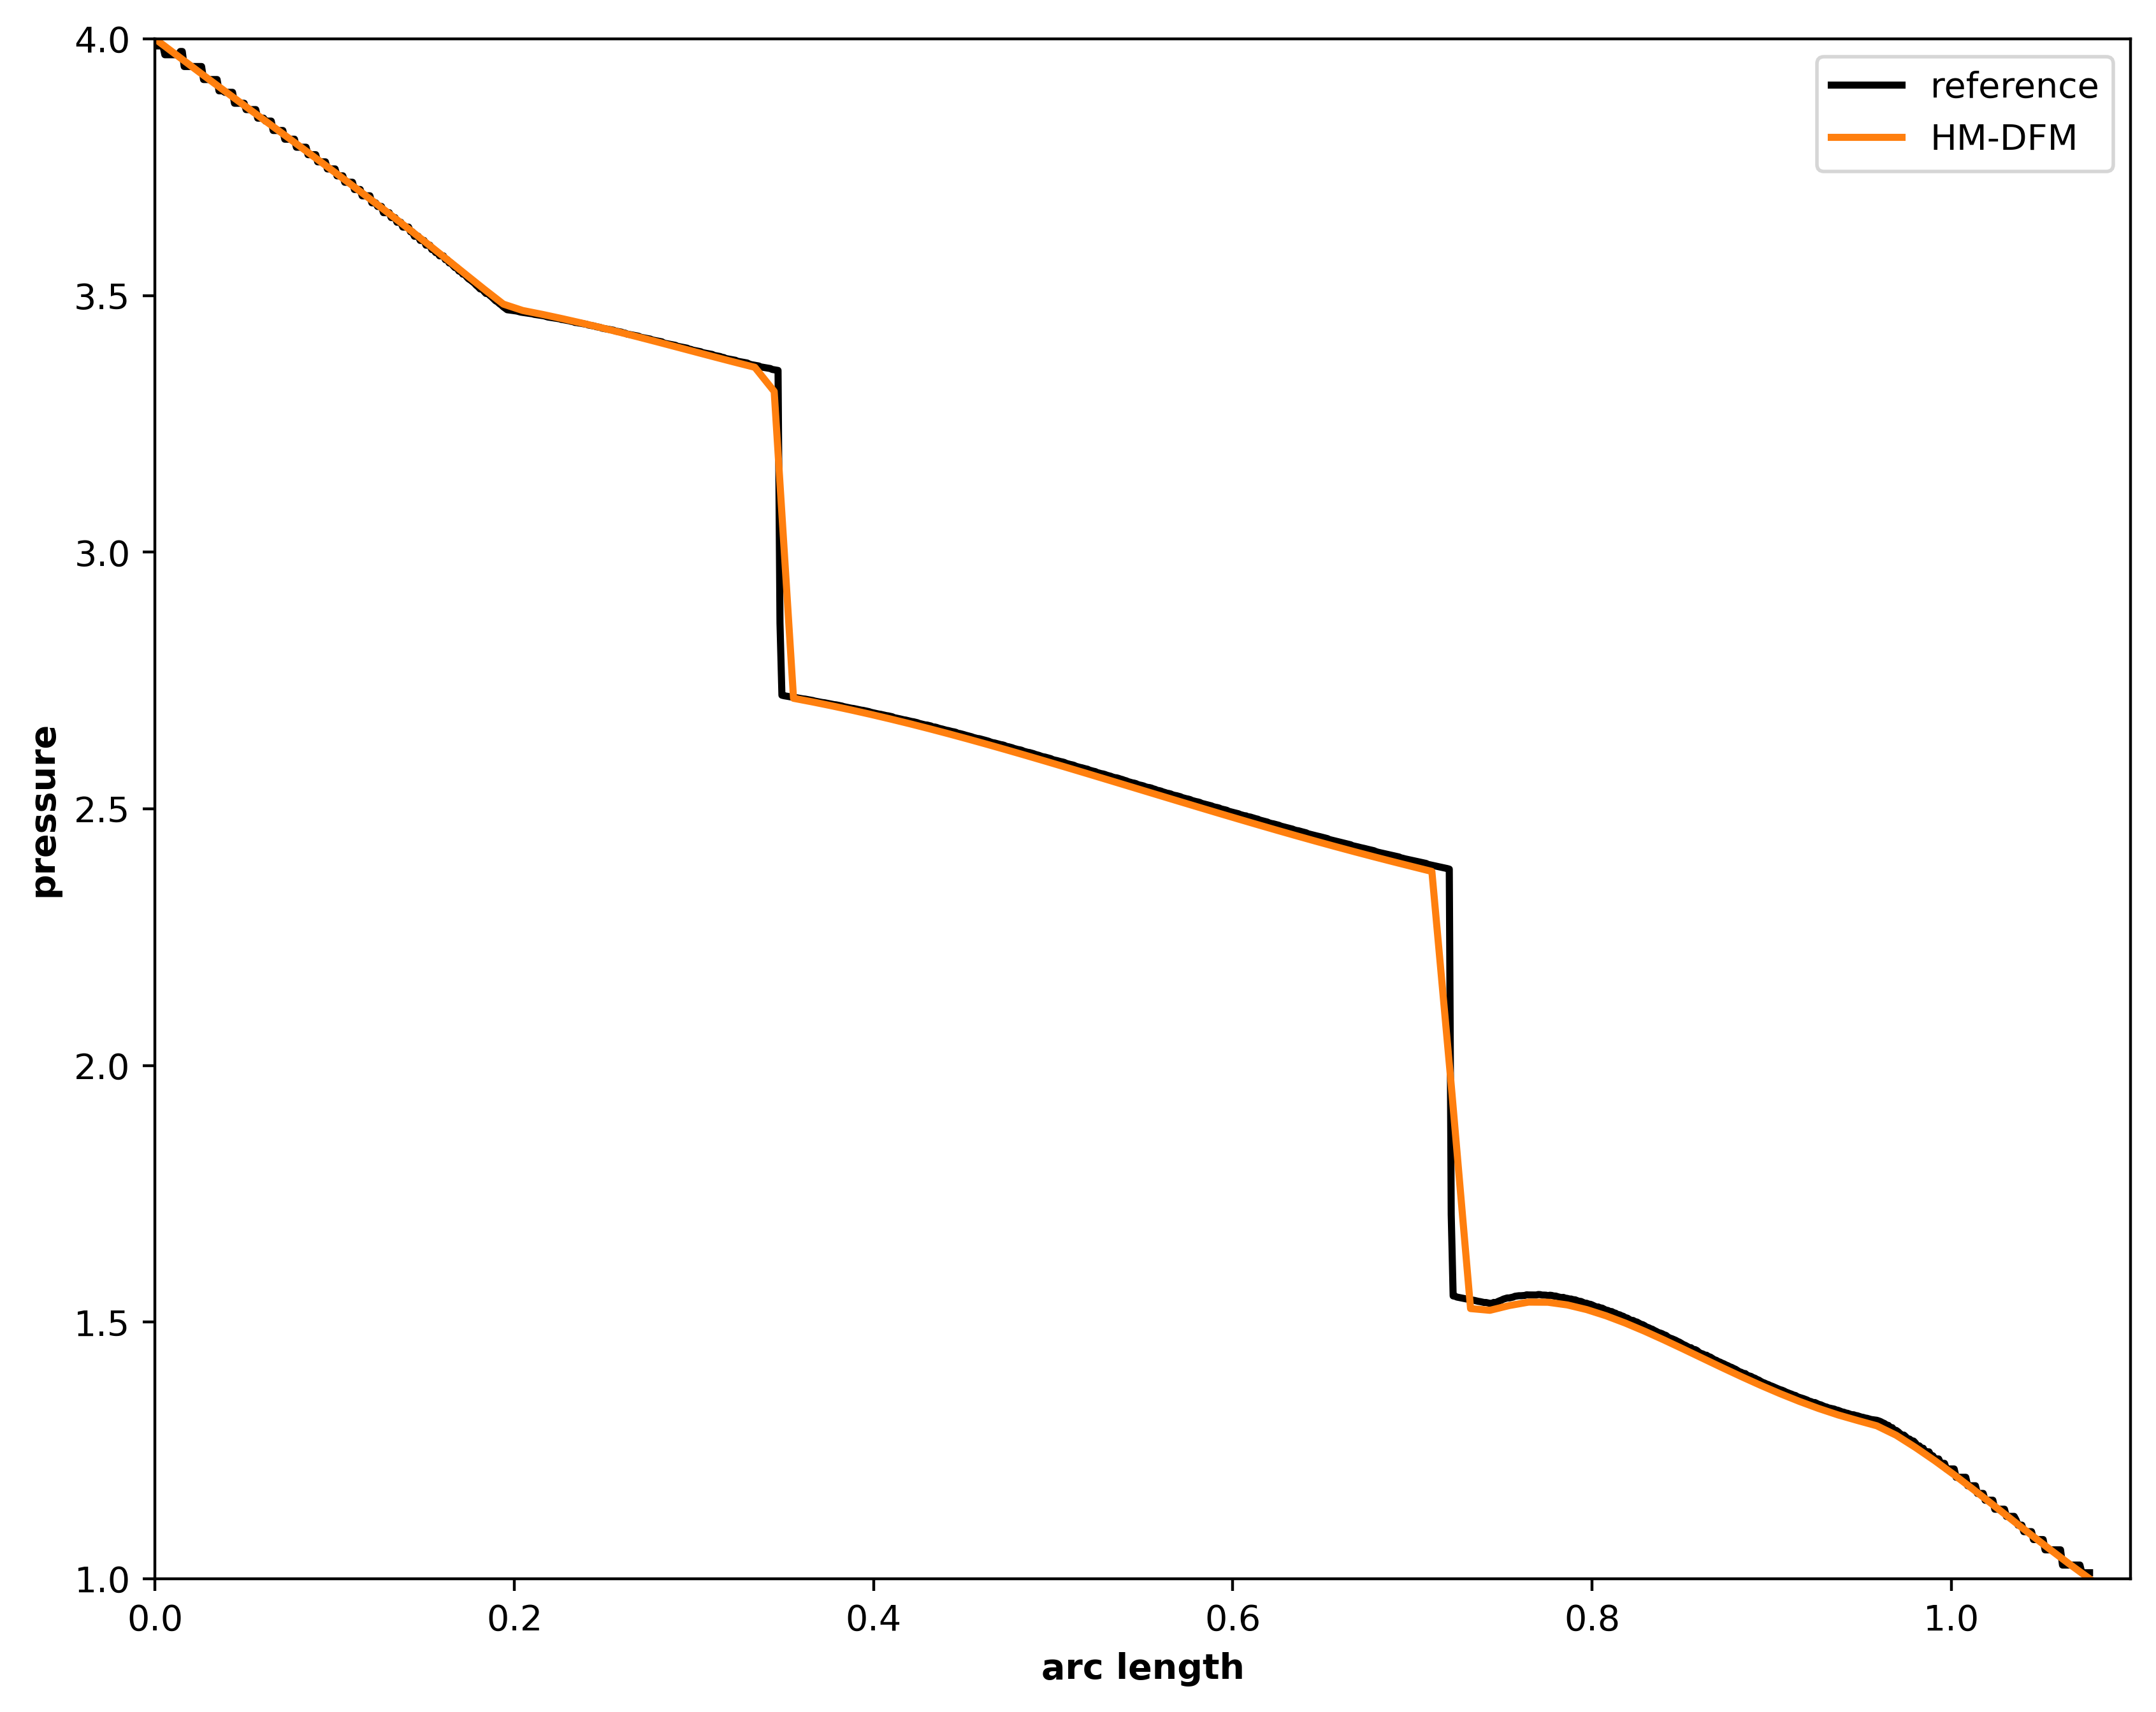

In [16]:
xx = np.linspace(0, 1, 101)
pp = []
for nref in [0,3]:
    for case in [1,2]:
        for order in [0,1,2]:
            if order==0: 
                s=2
            else:
                s=3
            mesh, ph, uh = HDG(order=order, nref=nref, s=s, case=case)
            filename = "data/complex-m"+str(nref)+"p"+str(order)+"c"+str(case)
            vtkout = VTKOutput(ma=mesh, coefs=[ph, uh], names=["ph","uh"], 
                               filename=filename, subdivision=order)
            vtkout.Do()
            if case==1:
                pp.append(np.array([ph(mesh(xx0,0.9+(xx0-1)*0.4)) for xx0 in xx]))
            else:
                pp.append(np.array([ph(mesh(xx0,0.9+(xx0-1)*0.4)) for xx0 in xx]))

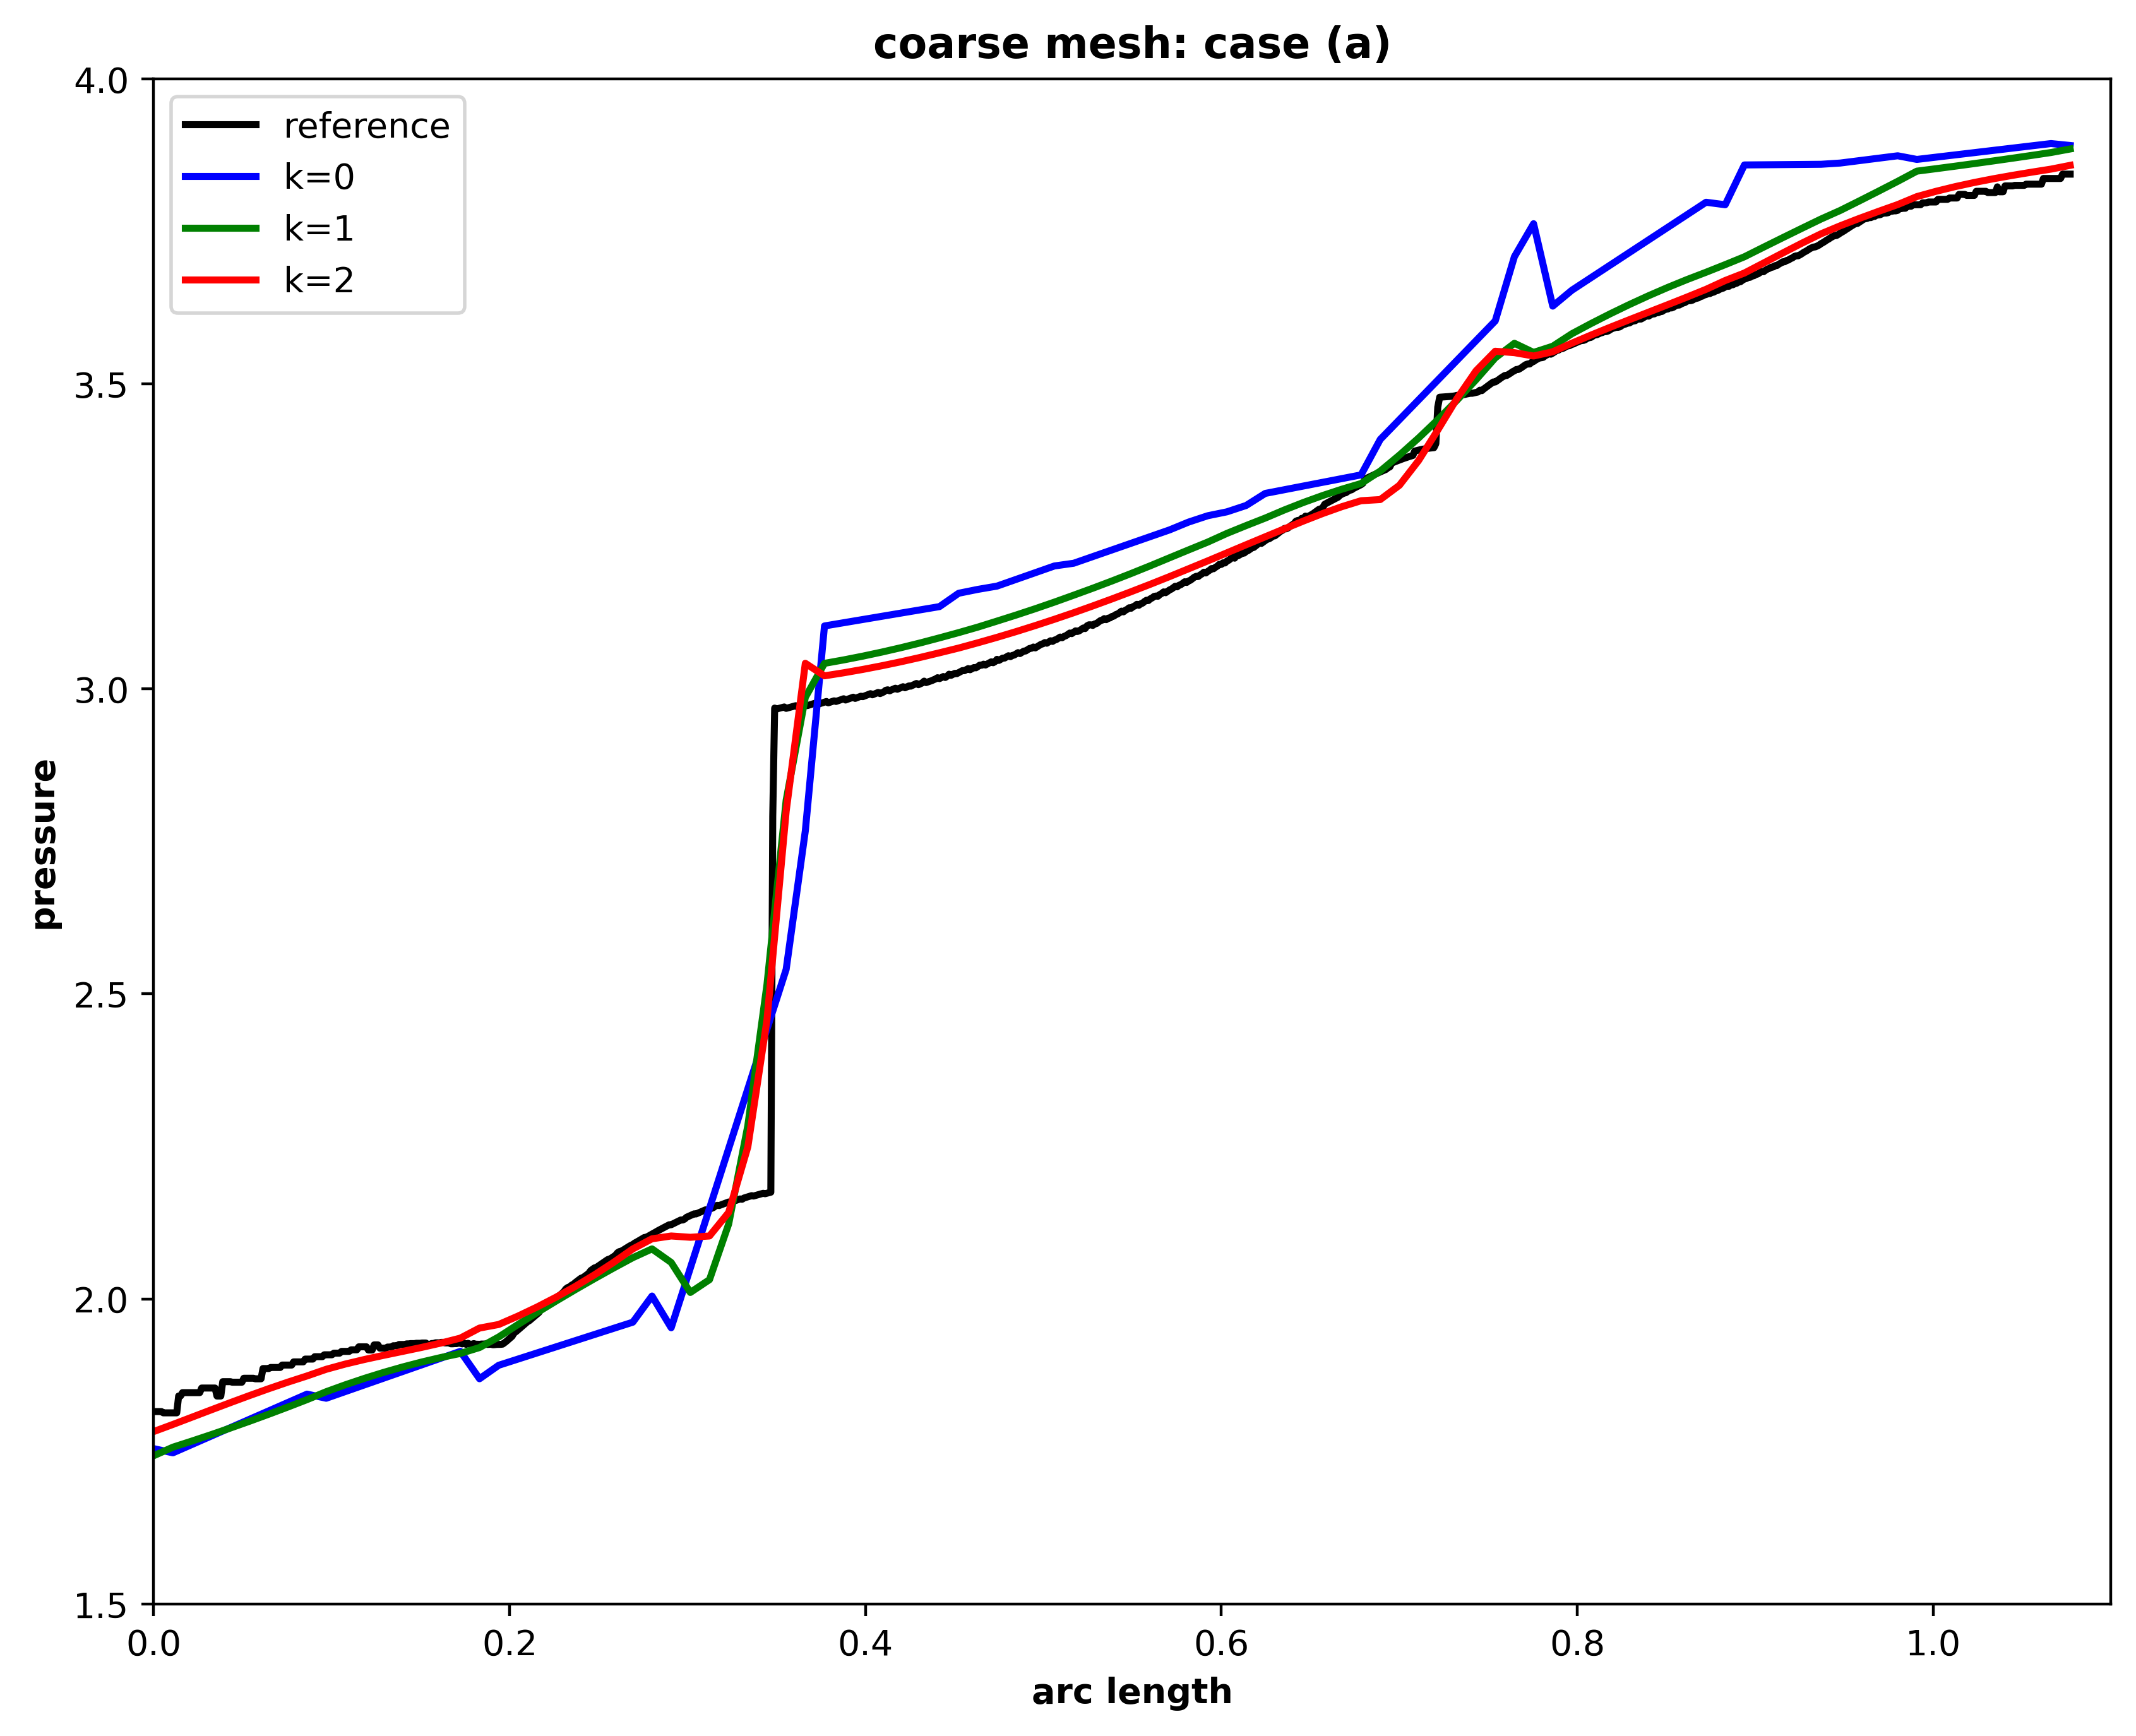

In [17]:
plt.figure(figsize=(10,8), dpi=400)

plt.plot(ref2.T[3]*(1.16)**0.5, ref2.T[0], "k", linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[0], 'b', linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[1], 'g', linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[2], 'r', linewidth=2)
plt.legend(["reference", "k=0", "k=1", "k=2"])
plt.axis([0,1.1, 1.5,4])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.title("coarse mesh: case (a)", fontweight='bold')

plt.savefig("data/complexAc.png", dpi=400)

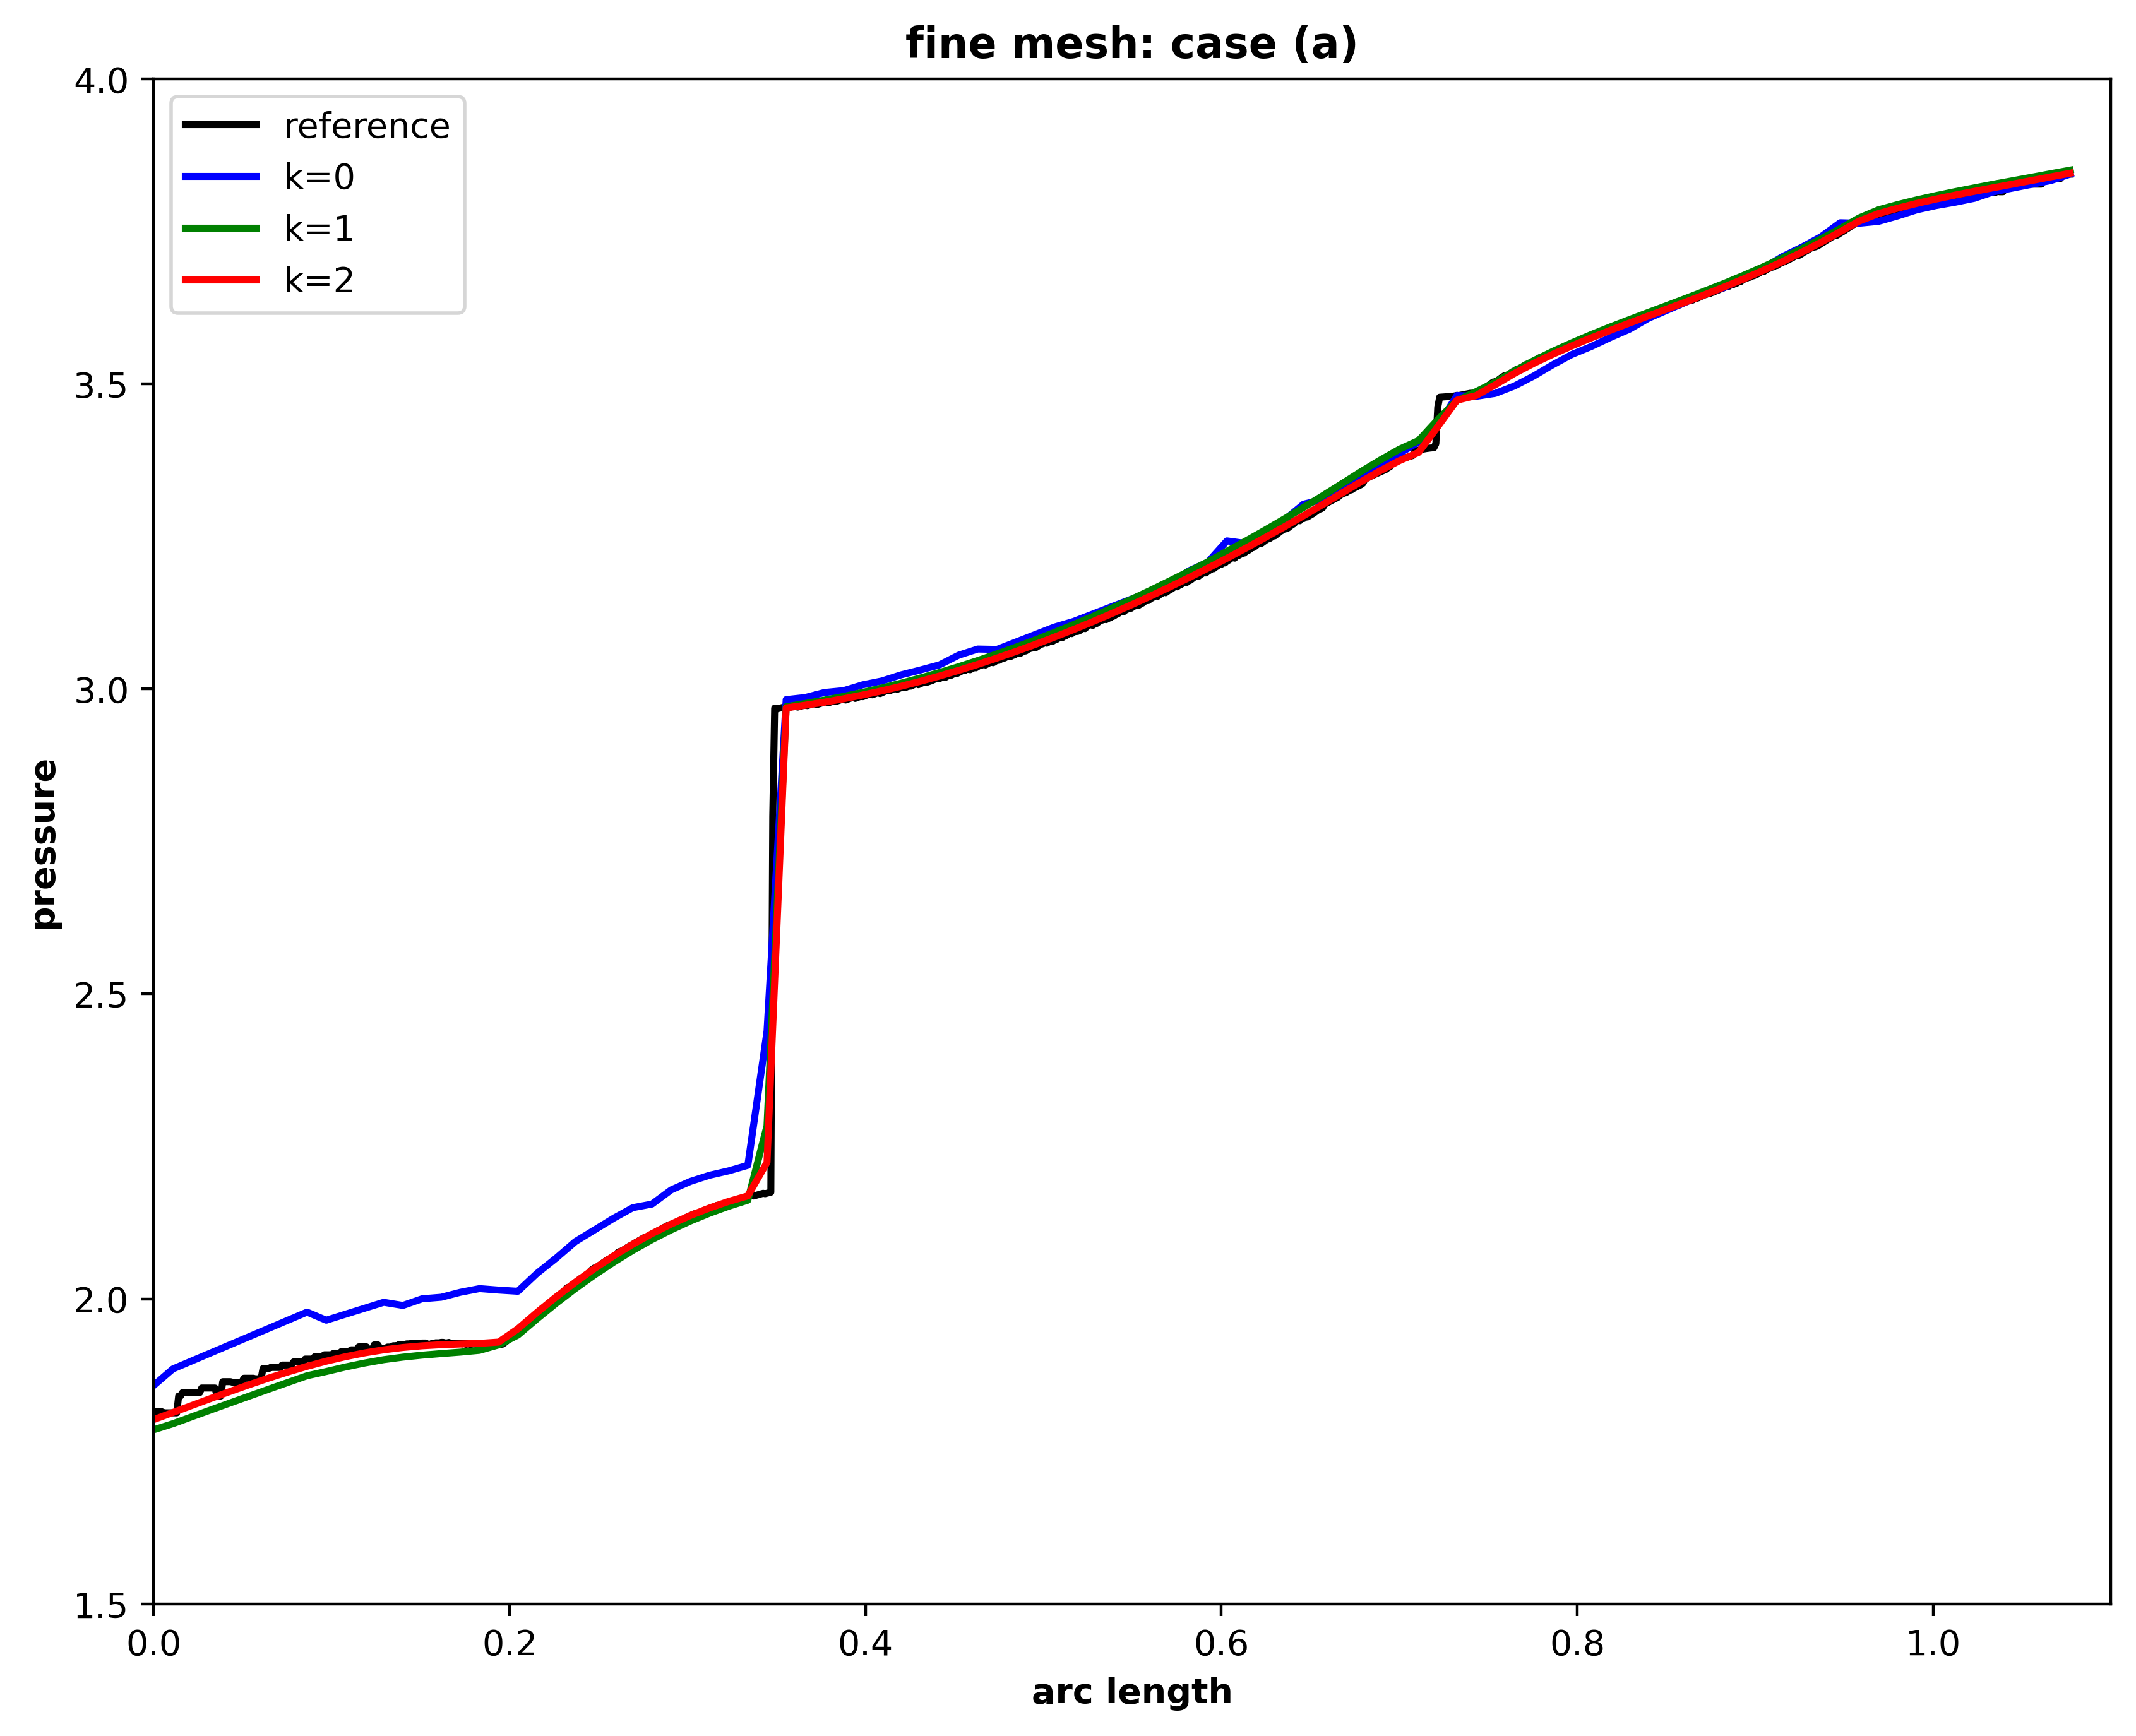

In [18]:
plt.figure(figsize=(10,8), dpi=400)

plt.plot(ref2.T[3]*(1.16)**0.5, ref2.T[0], "k", linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[6], 'b', linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[7], 'g', linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[8], 'r', linewidth=2)
plt.legend(["reference", "k=0", "k=1", "k=2"])
plt.axis([0,1.1, 1.5,4])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.title("fine mesh: case (a)", fontweight='bold')

plt.savefig("data/complexAf.png", dpi=400)

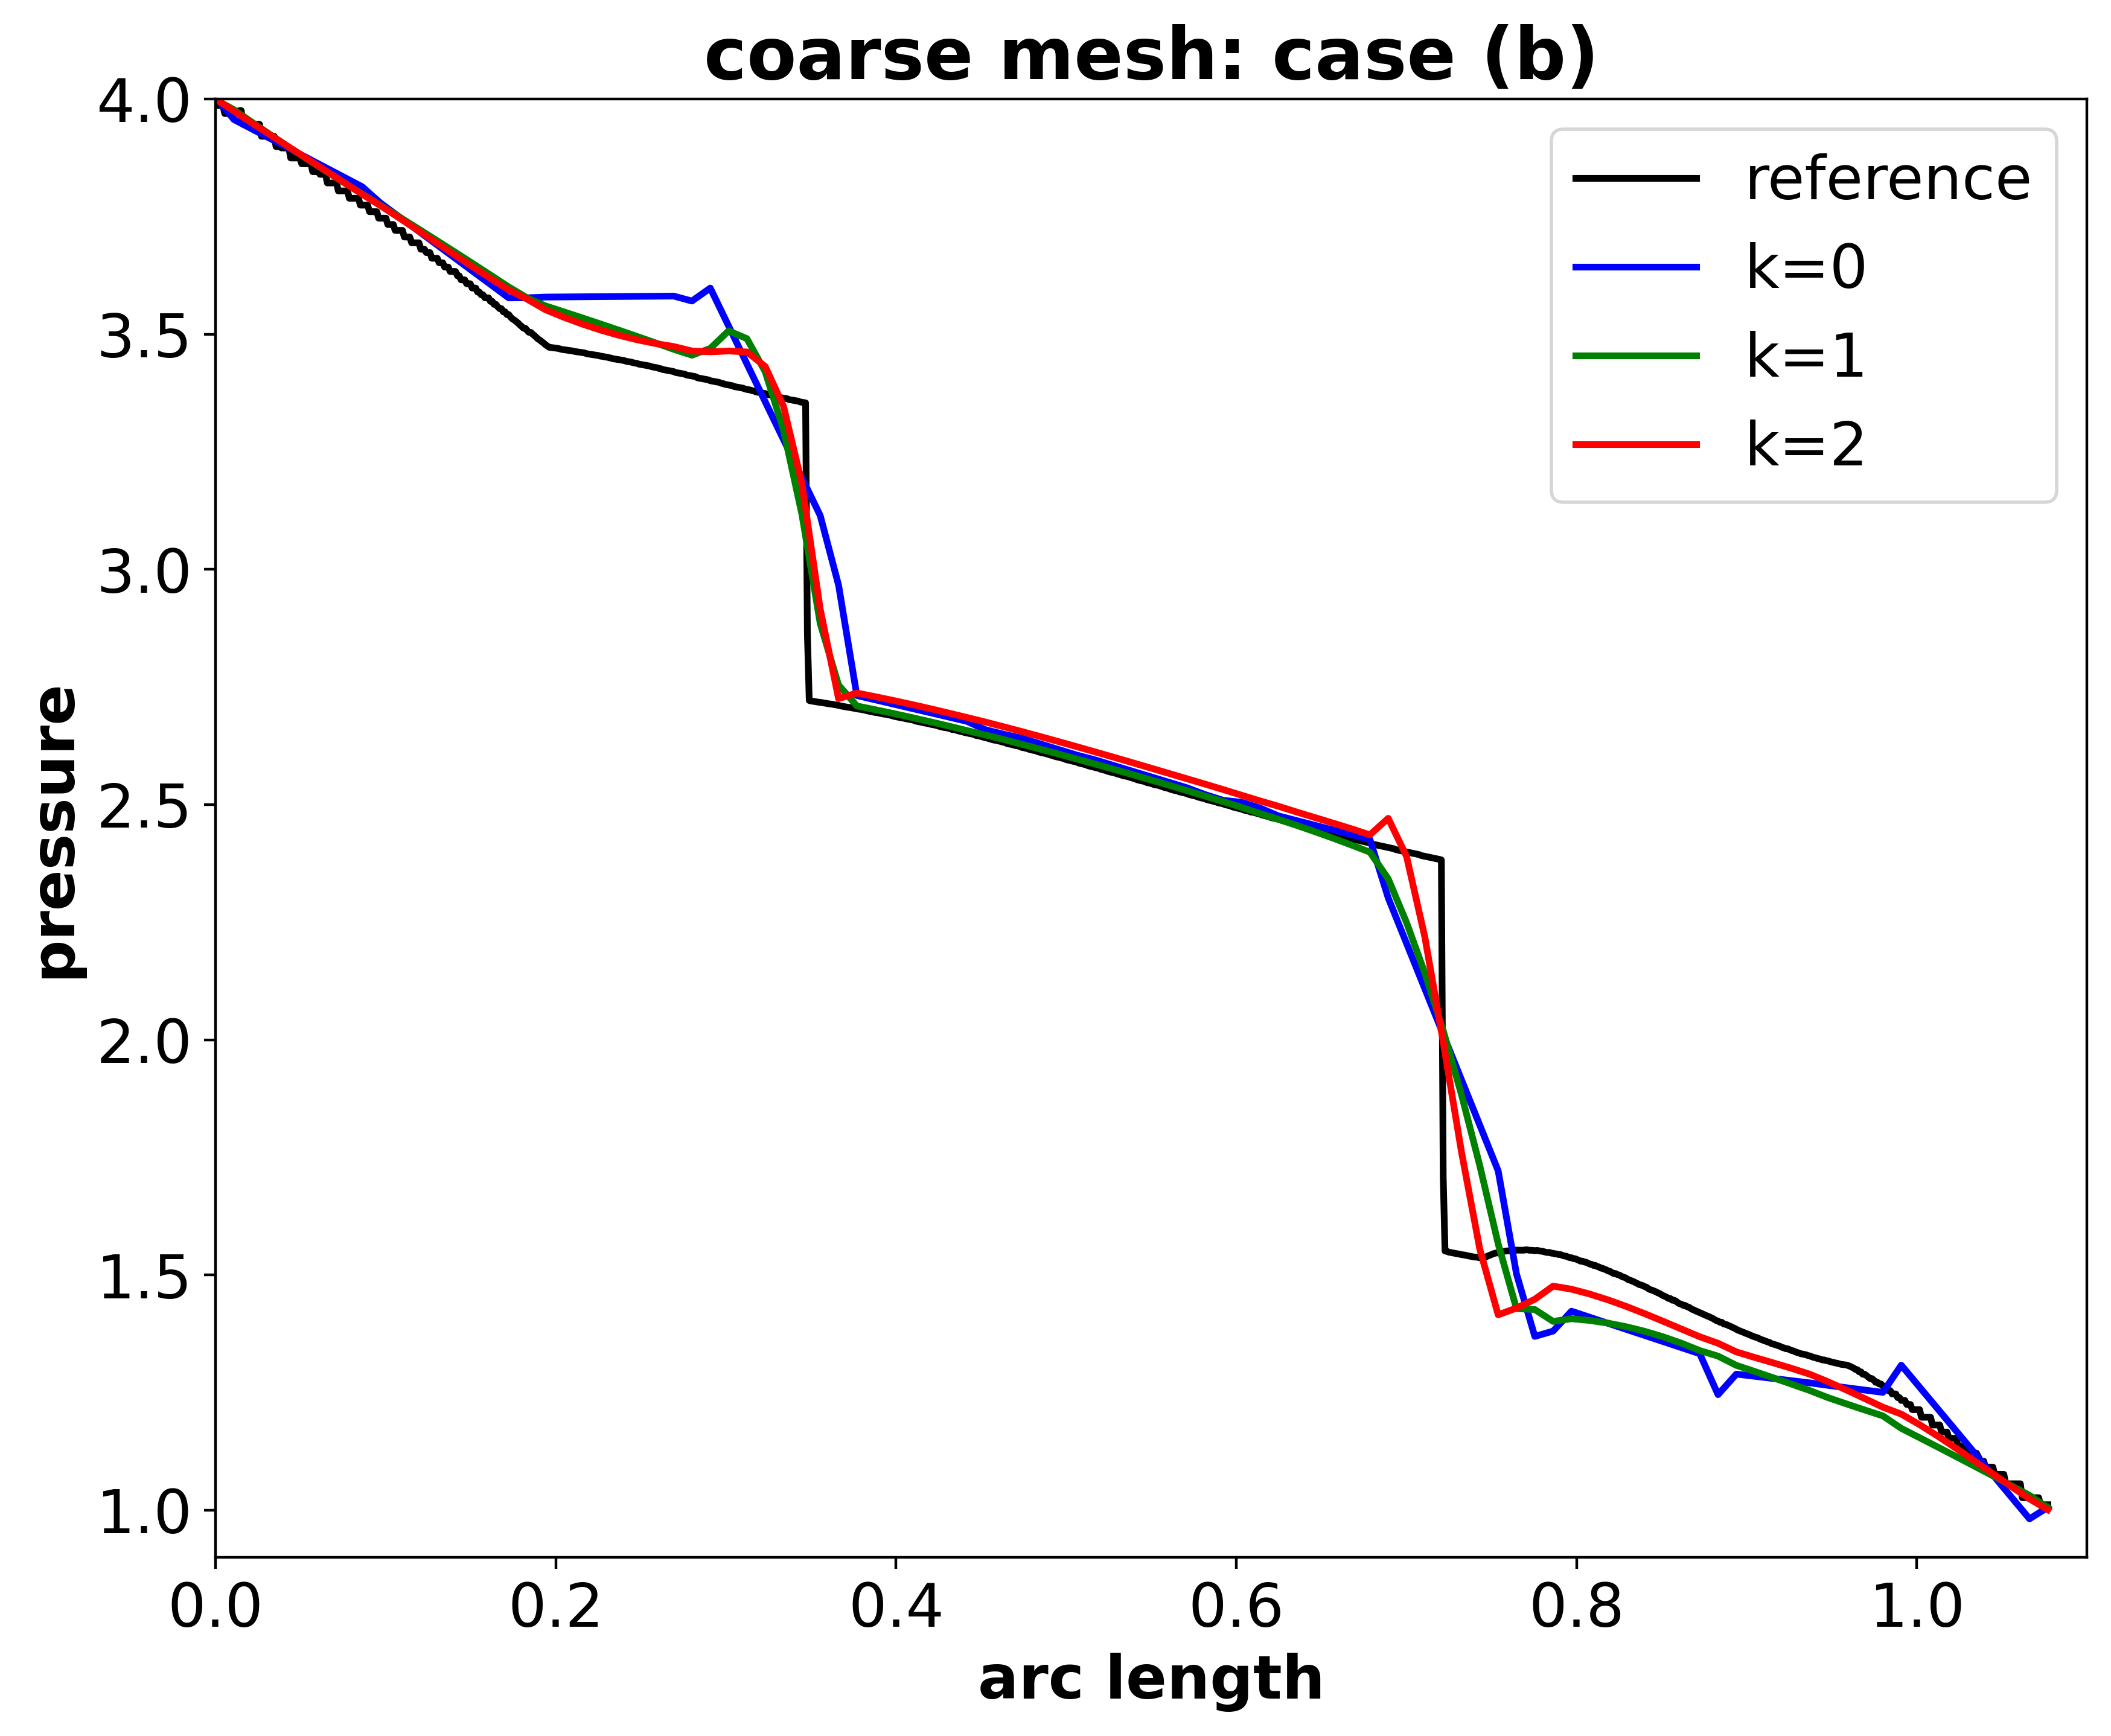

In [50]:
plt.figure(figsize=(10,8), dpi=400)

plt.plot(ref1.T[3]*(1.16)**0.5, ref1.T[0], "k", linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[3], 'b', linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[4], 'g', linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[5], 'r', linewidth=2)
plt.legend(["reference", "k=0", "k=1", "k=2"])
plt.axis([0,1.1, 0.9,4])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.title("coarse mesh: case (b)", fontweight='bold')

plt.savefig("data/complexBc.png", dpi=400)

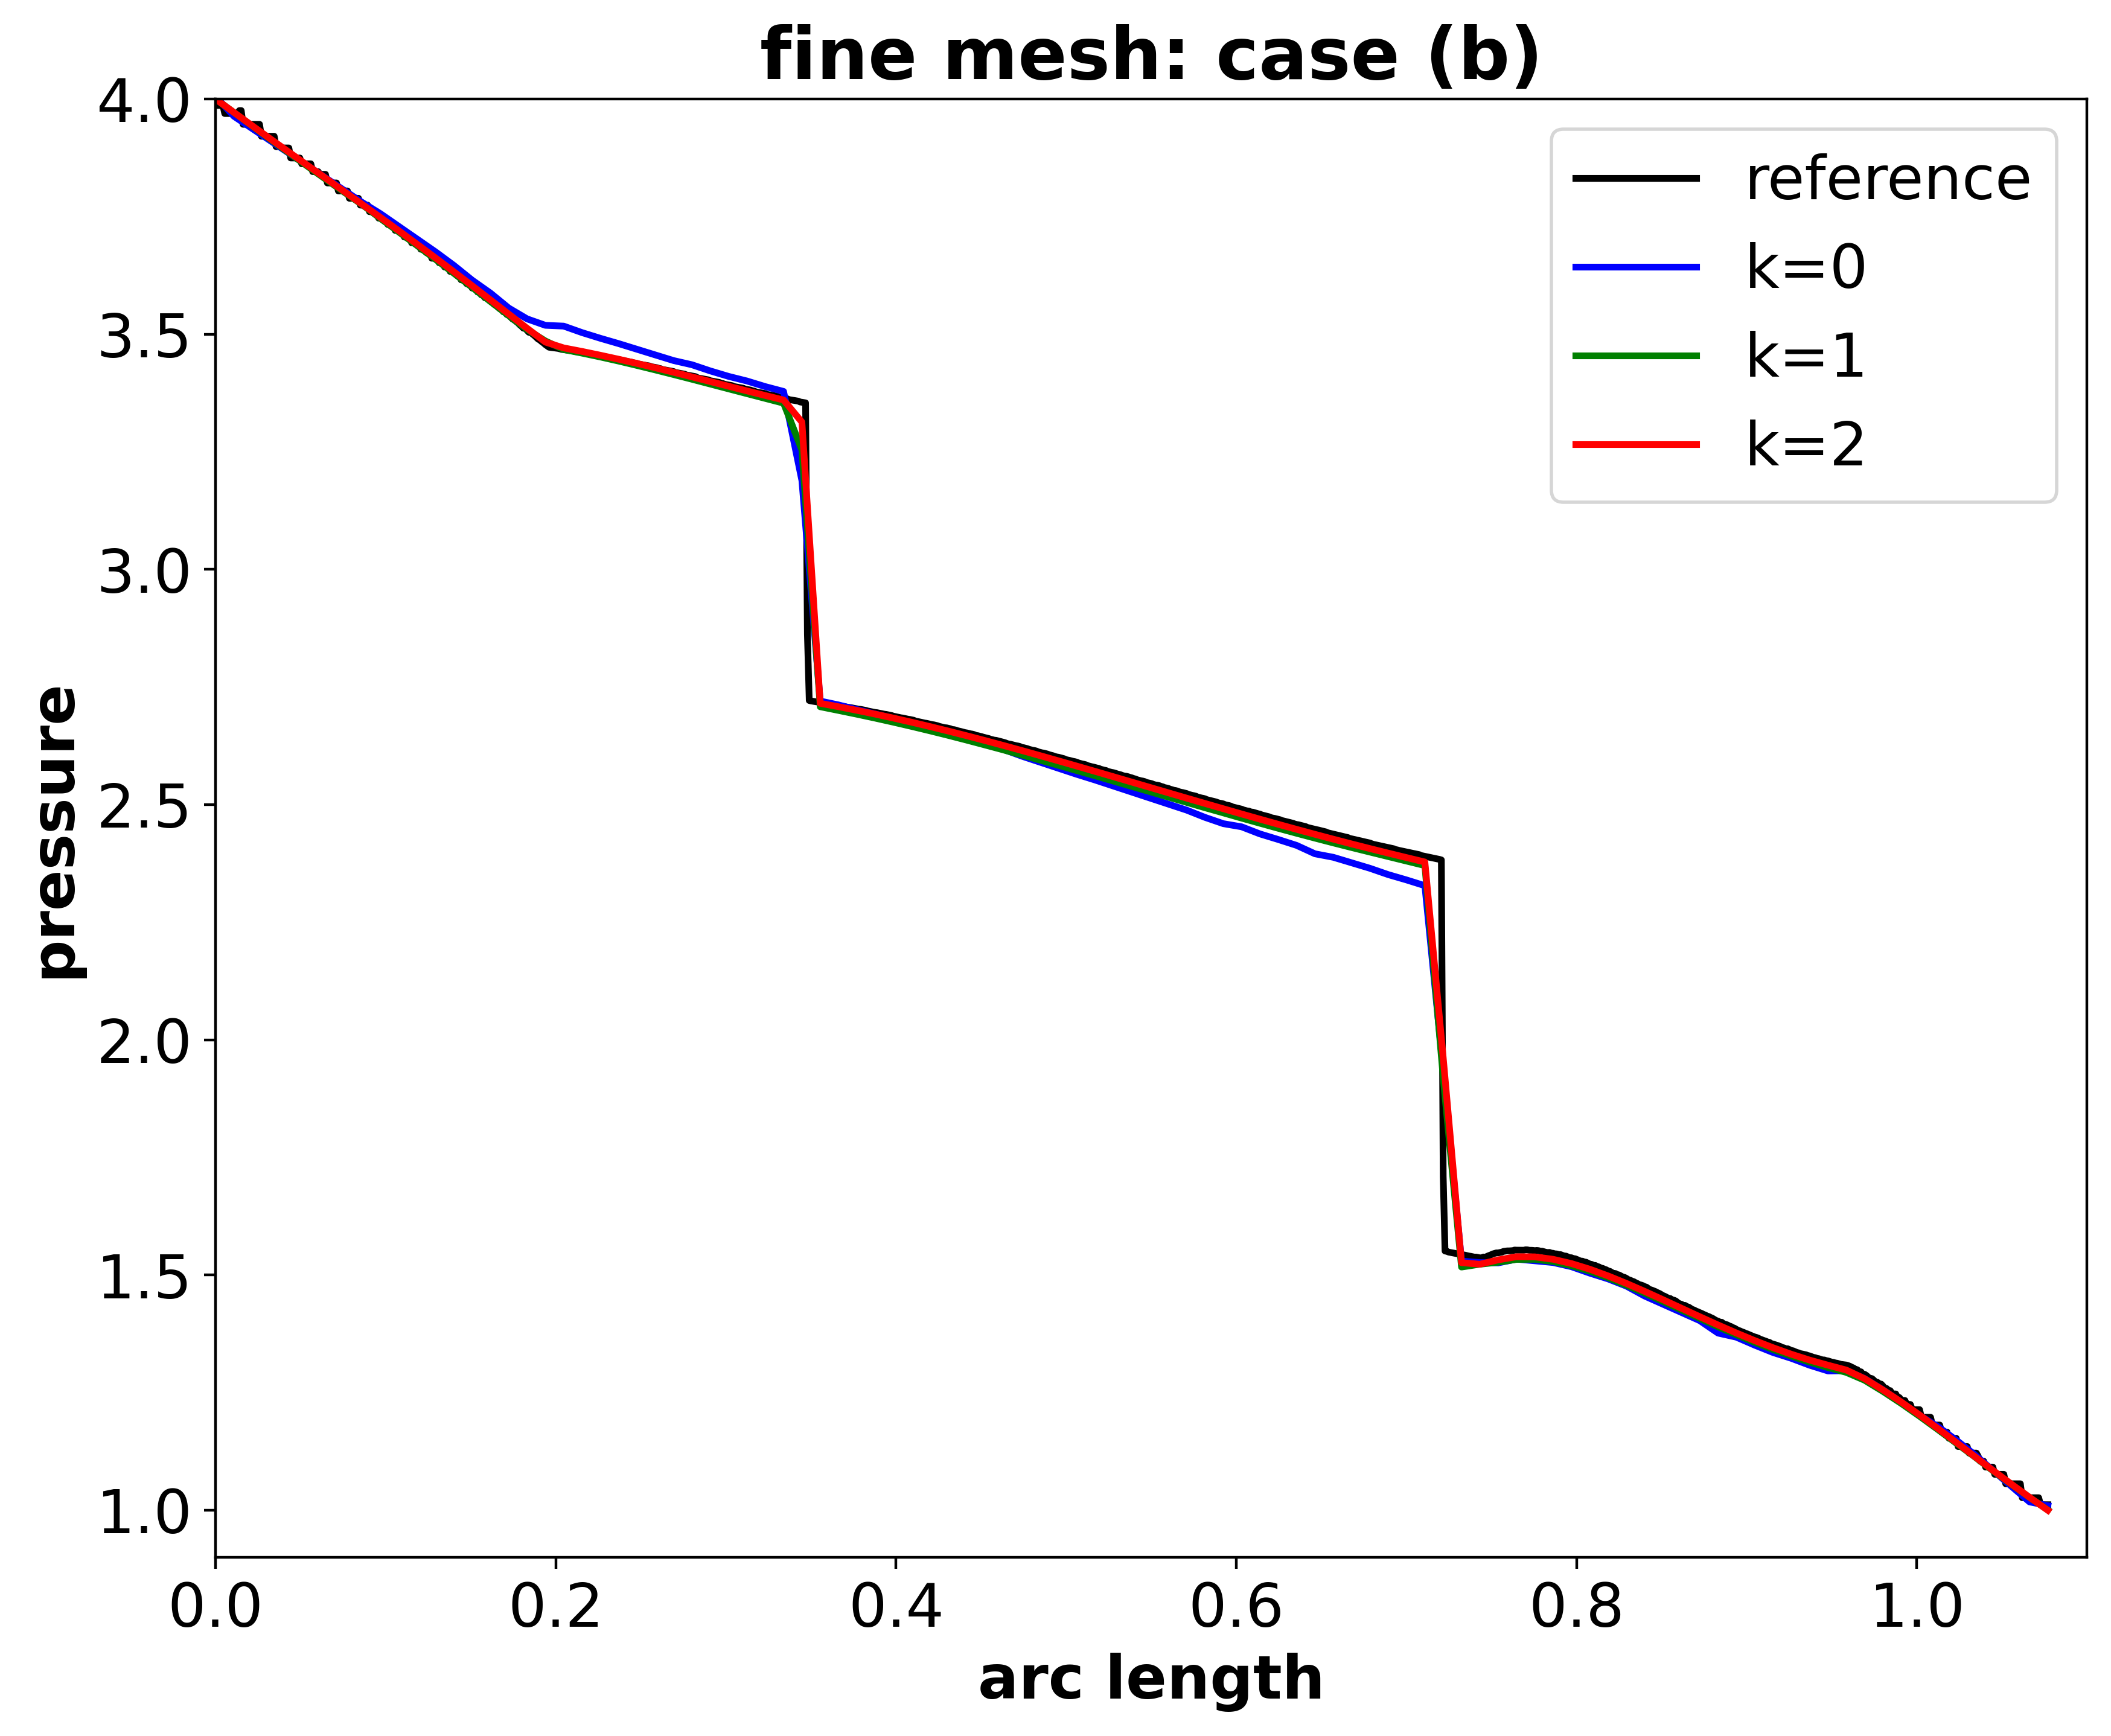

In [49]:
plt.figure(figsize=(10,8), dpi=400)

plt.plot(ref1.T[3]*(1.16)**0.5, ref1.T[0], "k", linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[9], 'b', linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[10], 'g', linewidth=2)
plt.plot(xx*(1.16)**0.5, pp[11], 'r', linewidth=2)
plt.legend(["reference", "k=0", "k=1", "k=2"])
plt.axis([0,1.1, 0.9,4])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.title("fine mesh: case (b)", fontweight='bold')

plt.savefig("data/complexBf.png", dpi=400)